<a href="https://colab.research.google.com/github/claudialeguiza/AA1-TUIA-Kidonakis-Leguiza/blob/navegador/TP_integrador_AA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Trabajo práctico

# **Aprendizaje Automático I**

### Tema: Predicción de lluvia en Australia.

## Integrantes:

    
*   Kidonakis, Sol
*   Leguiza, Claudia E





# Dataset

El dataset **weatherAUS.csv** contiene infomacion del clima de diferentes ciudades de Australia recopilada durante el periodo 2008 - 2017.

Contiene un total de 145412 observaciones y las siguientes columnas:

* **Sunshine:** Numero de horas de sol en el dia
* **Rainfall:** Cantidad de lluvia en el dia en mm
* **Evaporation:** La denominada evaporación del recipiente Clase A (mm) en el período de 24 horas a las 9 a.m.
* **WindGustDir:** La dirección de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche
* **WindGustSpeed:** La velocidad (km/h) de la ráfaga de viento más fuerte en las 24 horas previas a la medianoche
* **WindDir9am:** Dirección del viento a las 9 a.m.
* **WindDir3pm:** direccion del viento alas 3pm
* **WindSpeed9am:** Velocidad del viento (km/h) promediada durante 10 minutos antes de las 9 a.m.
* **WindSpeed3pm:** Velocidad del viento (km/h) promediada durante 10 minutos antes de las 3 p.m.
* **Humidity9am:** Humedad (porcentaje) a las 09:00 horas.
* **Humidity3pm:** Humedad (porcentaje) a las 15:00 horas.
* **Pressure9am:** La presión atmosférica (hpa) se redujo al nivel medio del mar a las 9 a.m.
* **Pressure3pm:** La presión atmosférica (hpa) se redujo al nivel medio del mar a las 3 p.m.
* **Cloud9am:** Fracción del cielo oscurecida por las nubes a las 9:00 am . Esto se mide en "oktas", que son una unidad de octavos. Registra cuántas octavas partes del cielo están oscurecidas por las nubes. Una medida 0 indica cielo completamente despejado mientras que un 8 indica que está completamente nublado.
* **Cloud3pm:** Fracción del cielo oscurecida por las nubes a las 3:00 pm
* **Temp9am:** Temperatura (grados C) a las 9 a.m.
* **Temp3pm:** Temperatura (grados C) a las 3 p.m.
* **RainToday:** Indica si el dia de la observacion llueve o no.

* **RainTomorrow:** La cantidad de lluvia caida del día siguiente en mm.
* **RainfallTomorrow:** Indica si el día siguiente de la observacion llovio o no.

  




# Objetivo:

  Predecir las target **RainTomorrow** y **RainfallTomorrow** en las ciudades de Adelaide, Canberra, Cobar, Dartmoor, Melbourne, MelbourneAirport, MountGambier, Sydney y SydneyAirport

In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.6 MB/s eta 0:00:00


In [3]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, log_loss, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Activation, Dropout
from keras.metrics import Precision
from keras.utils import to_categorical
from keras.optimizers import Adam
import shap
import tensorflow as tf
import  optuna
import time
import warnings
warnings.simplefilter('ignore')



## **Carga de dataset**

In [6]:
datos = pd.read_csv('/content/weatherAUS.csv', delimiter = ",")


In [7]:
datos.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


## **Preprocesamiento de los datos**

En los registros listados podemos ver que las columnas poseen datos de tipo numerico, fecha y object(string) y que en algunos de ellos hay datos nulos. por lo que aplicaremos distintas tecnicas de preprocesamiento de datos para su posterior analisis descriptivo.

La columna 'Location' contiene el nombre de las ciudades cuyo clima se ha cargado, por lo que las listamos para saber cuales son y verificamos la cantidad  de registros para confirmar que se han cargado todos.  

In [8]:
datos['Location'].unique()


array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [9]:
datos['Location'].count()

145412

Buscamos los registros correspondientes a las localidades en estudio.
Creamos un dataset nuevo con ellas.

In [10]:
datos['Location'].isin(( 'Sydney','SydneyAirport','Melbourne', 'MelbourneAirport','Canberra',\
                       'Adelaide', 'MountGambier','Cobar', 'Dartmoor' )).value_counts()

Location
False    117179
True      28233
Name: count, dtype: int64

In [11]:
df = datos[datos.Location\
                      .isin(( 'Sydney','SydneyAirport','Melbourne', 'MelbourneAirport',\
                             'Canberra','Adelaide', 'MountGambier','Cobar', 'Dartmoor' ))]

In [12]:
df


,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
6048,6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0
6049,6051,2009-01-03,Cobar,15.5,34.1,0.0,12.6,13.3,SE,30.0,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0
6050,6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0
6051,6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102515,102547,2017-06-20,MountGambier,6.2,16.3,0.0,NaN,NaN,N,41.0,...,70.0,1026.3,1024.1,NaN,NaN,8.7,15.5,No,Yes,2.0
102516,102548,2017-06-21,MountGambier,8.7,13.2,2.0,NaN,NaN,S,20.0,...,82.0,1029.2,1028.3,NaN,8.0,11.1,12.0,Yes,No,0.0
102517,102549,2017-06-22,MountGambier,7.0,15.7,0.0,NaN,NaN,N,31.0,...,67.0,1027.0,1022.4,8.0,NaN,10.0,14.9,No,No,0.0
102518,102550,2017-06-23,MountGambier,5.4,16.2,0.0,NaN,NaN,N,37.0,...,70.0,1017.0,1014.4,8.0,4.0,6.4,14.9,No,Yes,2.2


Analizamos cuantos datos por ciudad fueron registrados.

In [13]:
valores = df['Location'].value_counts()
valores

Location
Canberra            3435
Sydney              3343
Melbourne           3192
Adelaide            3192
MountGambier        3039
Cobar               3008
SydneyAirport       3008
MelbourneAirport    3008
Dartmoor            3008
Name: count, dtype: int64

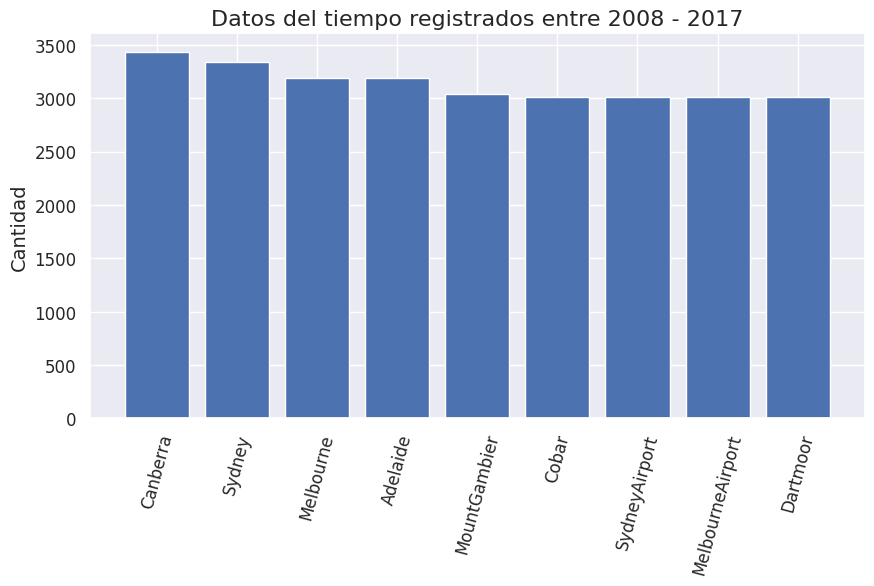

In [14]:
plt.figure(figsize=(10, 5))
plt.xticks(rotation=75, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Cantidad', fontsize=14)
plt.title('Datos del tiempo registrados entre 2008 - 2017',
          fontsize=16)
plt.bar(valores.index, valores)
plt.show()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28233 entries, 6047 to 102519
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        28233 non-null  int64  
 1   Date              28233 non-null  object 
 2   Location          28233 non-null  object 
 3   MinTemp           27663 non-null  float64
 4   MaxTemp           27675 non-null  float64
 5   Rainfall          27247 non-null  float64
 6   Evaporation       23880 non-null  float64
 7   Sunshine          21520 non-null  float64
 8   WindGustDir       26588 non-null  object 
 9   WindGustSpeed     26591 non-null  float64
 10  WindDir9am        26585 non-null  object 
 11  WindDir3pm        27796 non-null  object 
 12  WindSpeed9am      27875 non-null  float64
 13  WindSpeed3pm      27893 non-null  float64
 14  Humidity9am       27293 non-null  float64
 15  Humidity3pm       27343 non-null  float64
 16  Pressure9am       27394 non-null  float64

In [16]:
df.isnull().sum()

Unnamed: 0             0
Date                   0
Location               0
MinTemp              570
MaxTemp              558
Rainfall             986
Evaporation         4353
Sunshine            6713
WindGustDir         1645
WindGustSpeed       1642
WindDir9am          1648
WindDir3pm           437
WindSpeed9am         358
WindSpeed3pm         340
Humidity9am          940
Humidity3pm          890
Pressure9am          839
Pressure3pm          829
Cloud9am            9367
Cloud3pm            9550
Temp9am              585
Temp3pm              576
RainToday            986
RainTomorrow         985
RainfallTomorrow     985
dtype: int64

Vemos que ha excepcion de 'Location y 'Date',  el resto de las columnas poseen datos nulos.

Las ciudades de Cobar, Sidney Airport, Melbourn Airport y Dartmoort tienen 3008 registros.
Tomamos como referencia Cobar para averiguar la fecha que comienzan a registrarse mediciones para todas las ciudades.

In [17]:
df["Date"][df["Location"] == "Cobar"]

6047    2009-01-01
6048    2009-01-02
6049    2009-01-03
6050    2009-01-04
6051    2009-01-05
           ...    
9050    2017-06-20
9051    2017-06-21
9052    2017-06-22
9053    2017-06-23
9054    2017-06-24
Name: Date, Length: 3008, dtype: object

In [18]:
df[df["Date"] == "2009-01-01"]

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
30502,30511,2009-01-01,Sydney,18.4,34.7,0.0,9.8,12.9,NaN,NaN,...,22.0,1005.5,1000.7,4.0,6.0,22.0,34.3,No,No,0.0
33510,33520,2009-01-01,SydneyAirport,17.7,35.1,0.0,9.8,12.9,S,72.0,...,13.0,1005.3,1000.2,6.0,6.0,22.9,34.0,No,No,0.0
46000,46014,2009-01-01,Canberra,12.6,27.1,0.0,10.6,13.3,W,65.0,...,24.0,1003.1,1001.1,1.0,1.0,19.7,26.2,No,No,0.0
64171,64191,2009-01-01,MelbourneAirport,11.2,19.9,0.0,5.6,8.8,SW,69.0,...,37.0,1005.1,1006.4,7.0,7.0,15.9,18.1,No,Yes,1.2
67363,67384,2009-01-01,Melbourne,14.7,20.4,0.0,5.6,8.8,SW,69.0,...,39.0,1005.4,1006.5,7.0,7.0,15.9,19.6,No,No,0.2
80972,80998,2009-01-01,Dartmoor,NaN,NaN,NaN,4.8,6.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96473,96504,2009-01-01,Adelaide,16.9,22.9,0.0,NaN,10.9,SW,50.0,...,40.0,1011.3,1012.4,NaN,NaN,18.1,22.5,No,No,0.0
99512,99544,2009-01-01,MountGambier,12.6,17.0,0.8,4.8,6.5,SW,56.0,...,43.0,1008.3,1011.6,7.0,5.0,14.3,16.6,No,No,0.0


Estudiamos los datos de 2008

In [19]:
datos2008 = df[df['Date'] < '2009-01-01']
datos2008

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
30167,30176,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,Yes,6.0
30168,30177,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,Yes,6.6
30169,30178,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,Yes,18.8
30170,30179,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,Yes,77.4
30171,30180,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,Yes,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99507,99539,2008-12-27,MountGambier,12.9,22.8,0.0,4.6,13.4,W,39.0,...,50.0,1007.6,1005.6,4.0,7.0,18.0,21.6,No,No,0.0
99508,99540,2008-12-28,MountGambier,13.3,20.6,0.0,6.2,5.1,WNW,56.0,...,59.0,1004.6,1004.3,8.0,7.0,16.2,20.1,No,No,0.8
99509,99541,2008-12-29,MountGambier,10.7,19.1,0.8,4.8,9.3,W,48.0,...,49.0,1010.5,1009.8,5.0,7.0,16.2,17.9,No,Yes,6.0
99510,99542,2008-12-30,MountGambier,13.2,18.8,6.0,4.0,8.8,W,59.0,...,50.0,1006.2,1006.6,7.0,7.0,16.4,17.4,Yes,No,0.0


In [20]:
datos2008.isnull().sum()

Unnamed: 0            0
Date                  0
Location              0
MinTemp               1
MaxTemp               1
Rainfall             18
Evaporation          63
Sunshine              7
WindGustDir         342
WindGustSpeed       341
WindDir9am           48
WindDir3pm            5
WindSpeed9am         11
WindSpeed3pm          3
Humidity9am           1
Humidity3pm           1
Pressure9am           2
Pressure3pm           0
Cloud9am            184
Cloud3pm            184
Temp9am               1
Temp3pm               0
RainToday            18
RainTomorrow         18
RainfallTomorrow     18
dtype: int64

In [21]:
datos2008['Location'].unique()

array(['Sydney', 'Canberra', 'Melbourne', 'Adelaide', 'MountGambier'],
      dtype=object)

In [22]:
datos2008['Location'].value_counts()

Location
Canberra        427
Sydney          335
Melbourne       184
Adelaide        184
MountGambier     31
Name: count, dtype: int64

A partir del 1 de enero  de 2009 se registran datos del clima para todas las ciudades en estudio, por lo que decidimos descartar los datos correspondientes al año 2008.

Ordenamos el dataset y elegimos 2009-01-01 como fecha para truncamiento del dataset

In [23]:
df = df.sort_values(["Date"])
fecha_especifica = '2009-01-01'
df_filtrado = df[df['Date'] >= fecha_especifica]

df_filtrado.reset_index(drop = True, inplace = True)#Resetea el indice y no  crea uno  nuevo
df_filtrado

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,99544,2009-01-01,MountGambier,12.6,17.0,0.8,4.8,6.5,SW,56.0,...,43.0,1008.3,1011.6,7.0,5.0,14.3,16.6,No,No,0.0
1,96504,2009-01-01,Adelaide,16.9,22.9,0.0,NaN,10.9,SW,50.0,...,40.0,1011.3,1012.4,NaN,NaN,18.1,22.5,No,No,0.0
2,30511,2009-01-01,Sydney,18.4,34.7,0.0,9.8,12.9,NaN,NaN,...,22.0,1005.5,1000.7,4.0,6.0,22.0,34.3,No,No,0.0
3,80998,2009-01-01,Dartmoor,NaN,NaN,NaN,4.8,6.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,33520,2009-01-01,SydneyAirport,17.7,35.1,0.0,9.8,12.9,S,72.0,...,13.0,1005.3,1000.2,6.0,6.0,22.9,34.0,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27067,49021,2017-06-24,Canberra,0.1,14.4,0.0,NaN,NaN,NW,48.0,...,45.0,1017.5,1016.2,NaN,NaN,9.1,13.0,No,No,0.0
27068,84005,2017-06-24,Dartmoor,6.2,11.8,3.0,NaN,NaN,W,20.0,...,70.0,1019.8,1017.8,NaN,NaN,6.9,10.9,Yes,No,0.2
27069,9056,2017-06-24,Cobar,8.3,16.2,0.0,NaN,NaN,WSW,20.0,...,49.0,1020.2,1018.5,NaN,7.0,14.2,14.5,No,No,0.0
27070,99511,2017-06-24,Adelaide,5.0,17.3,0.0,NaN,NaN,W,17.0,...,54.0,1020.7,1018.5,NaN,NaN,9.6,16.7,No,No,0.0


In [24]:
df_filtrado['Location'].value_counts()

Location
MountGambier        3008
Adelaide            3008
Sydney              3008
Dartmoor            3008
SydneyAirport       3008
Cobar               3008
Melbourne           3008
Canberra            3008
MelbourneAirport    3008
Name: count, dtype: int64

In [25]:
df_filtrado = df_filtrado.drop('Unnamed: 0', axis =1)

## **Particion del dataset en train y test**

Vamos a destinar el 80% de los datos a training y 20% a test

In [26]:
train = (len(df_filtrado.index) * 0.8)
train

21657.600000000002

In [27]:
test = len(df_filtrado.index) * 0.2
test

5414.400000000001

Dado que el dataset, se trata de una serie temporal, decidimos para el train quedarnos con los primeros 21658 registros y  5414 para test.

In [28]:
df_train  = df_filtrado.iloc[:21658]
df_train

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2009-01-01,MountGambier,12.6,17.0,0.8,4.8,6.5,SW,56.0,SW,...,43.0,1008.3,1011.6,7.0,5.0,14.3,16.6,No,No,0.0
1,2009-01-01,Adelaide,16.9,22.9,0.0,NaN,10.9,SW,50.0,SW,...,40.0,1011.3,1012.4,NaN,NaN,18.1,22.5,No,No,0.0
2,2009-01-01,Sydney,18.4,34.7,0.0,9.8,12.9,NaN,NaN,W,...,22.0,1005.5,1000.7,4.0,6.0,22.0,34.3,No,No,0.0
3,2009-01-01,Dartmoor,NaN,NaN,NaN,4.8,6.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-01,SydneyAirport,17.7,35.1,0.0,9.8,12.9,S,72.0,NW,...,13.0,1005.3,1000.2,6.0,6.0,22.9,34.0,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21653,2015-10-31,Dartmoor,12.8,27.7,3.8,3.6,12.0,ENE,43.0,ENE,...,34.0,1011.4,1008.5,NaN,NaN,19.5,26.8,Yes,No,0.0
21654,2015-11-01,Canberra,8.9,25.3,2.2,NaN,NaN,W,57.0,NW,...,60.0,1015.7,1010.7,NaN,8.0,18.1,20.8,Yes,Yes,19.4
21655,2015-11-01,SydneyAirport,17.5,28.7,0.0,7.8,9.0,N,56.0,NNE,...,54.0,1015.0,1010.1,1.0,3.0,22.4,26.7,No,Yes,9.8
21656,2015-11-01,Dartmoor,9.9,17.8,0.0,6.6,1.8,W,30.0,NW,...,70.0,1010.1,1008.8,NaN,NaN,14.5,16.9,No,No,1.0


In [29]:
df_test = df_filtrado.iloc[21658:]
df_test

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
21658,2015-11-01,MelbourneAirport,15.0,27.0,4.8,7.0,5.2,N,72.0,N,...,59.0,1008.3,1006.7,4.0,7.0,21.2,21.0,Yes,No,0.2
21659,2015-11-01,Cobar,16.7,30.2,2.4,7.2,NaN,W,65.0,NE,...,45.0,1012.9,1008.3,6.0,6.0,21.6,28.2,Yes,Yes,7.6
21660,2015-11-01,MountGambier,12.0,18.3,0.0,6.6,1.8,WNW,37.0,WNW,...,77.0,1010.7,1009.0,8.0,7.0,14.9,15.3,No,Yes,2.6
21661,2015-11-01,Sydney,17.5,26.8,0.0,7.8,9.0,NE,44.0,E,...,59.0,1015.2,1010.6,1.0,3.0,21.9,25.4,No,Yes,26.0
21662,2015-11-01,Melbourne,NaN,NaN,NaN,7.0,5.2,N,72.0,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27067,2017-06-24,Canberra,0.1,14.4,0.0,NaN,NaN,NW,48.0,N,...,45.0,1017.5,1016.2,NaN,NaN,9.1,13.0,No,No,0.0
27068,2017-06-24,Dartmoor,6.2,11.8,3.0,NaN,NaN,W,20.0,NW,...,70.0,1019.8,1017.8,NaN,NaN,6.9,10.9,Yes,No,0.2
27069,2017-06-24,Cobar,8.3,16.2,0.0,NaN,NaN,WSW,20.0,W,...,49.0,1020.2,1018.5,NaN,7.0,14.2,14.5,No,No,0.0
27070,2017-06-24,Adelaide,5.0,17.3,0.0,NaN,NaN,W,17.0,NaN,...,54.0,1020.7,1018.5,NaN,NaN,9.6,16.7,No,No,0.0


### **Funciones**

In [30]:
def preprocesamiento(data):
    data.info()
    data.isna().sum()

    # Definir columnas con valores nulos
    columnas_con_nulos = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                          'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm','Humidity9am',
                          'Humidity3pm', 'Pressure9am','Pressure3pm', 'Cloud9am',
                          'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainfallTomorrow']

    # Rellenar valores faltantes en 'RainToday' y 'RainTomorrow'
    data['RainToday'] = data.groupby('Date')['RainToday'].transform(lambda x: x.fillna(x.mode().iloc[0]))
    data['RainTomorrow'] = data.groupby('Date')['RainTomorrow'].transform(lambda x: x.fillna(x.mode().iloc[0]))

    # Rellenar valores faltantes en direcciones del viento
    data['WindGustDir'] = data.groupby('Date')['WindGustDir'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.isna().all() else x)
    data['WindDir9am'] = data.groupby('Date')['WindDir9am'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.isna().all() else x)
    data['WindDir3pm'] = data.groupby('Date')['WindDir3pm'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.isna().all() else x)

    # Rellenar valores faltantes con la media por día para las columnas especificadas
    media_por_dia = data.groupby('Date')[columnas_con_nulos].transform('mean')
    data[columnas_con_nulos] = data[columnas_con_nulos].fillna(media_por_dia)

    data['Date'] = pd.to_datetime(data['Date'])

    return data



In [31]:
def crear_columna_season(data):
   data['season'] = data['Date'].apply(asignar_estacion)
   return data

In [36]:
def asignar_estacion(fecha):
    mes = fecha.month
    if mes in [12, 1, 2]:  # Verano: Diciembre, Enero, Febrero
        return 'Summer'
    elif mes in [3, 4, 5]:  # Otoño: Marzo, Abril, Mayo
        return 'Autumn'
    elif mes in [6, 7, 8]:  # Invierno: Junio, Julio, Agosto
        return 'Winter'
    else:  # Primavera: Septiembre, Octubre, Noviembre
        return 'Spring'

In [32]:
def codificar_variables(data):

  data1 = data.copy()

  for var in ["SW", "S", 'SSW', 'W', 'SSE', 'E', 'SE', 'NE', 'NNE', 'WSW', 'WNW',
            'NW', 'N', 'ESE', 'ENE']:
    # Crear columnas para WindGustDir
    data1[f'WindGustDir_{var}'] = 0
    data1.loc[data['WindGustDir'] == var, f'WindGustDir_{var}'] = 1

    # Crear columnas para WindGust9am
    data1[f'WindDir9am_{var}'] = 0
    data1.loc[data['WindDir9am'] == var, f'WindDir9am_{var}'] = 1

    # Crear columnas para WindGust3pm
    data1[f'WindDir3pm_{var}'] = 0
    data1.loc[data['WindDir3pm'] == var, f'WindDir3pm_{var}'] = 1

    # Generamos dummys
    # Codificar la variable 'RainToday'
  data1 = pd.get_dummies(data1, columns=['RainToday'],drop_first=True)

    # Codificar la variable 'RainTomorrow'
  data1 = pd.get_dummies(data1, columns=['RainTomorrow'],drop_first=True)

    # Codificar la variable 'season'
  data1 = pd.get_dummies(data1, columns=['season'],drop_first=True)

    # Codificar la variable 'Location'
  data1 = pd.get_dummies(data1, columns=['Location'], drop_first=True)
  data1 = data1.drop(columns= ['Date', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])

  return data1

## Preprocesamiento

In [37]:
df_filtrado = preprocesamiento(df_filtrado)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27072 entries, 0 to 27071
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              27072 non-null  datetime64[ns]
 1   Location          27072 non-null  object        
 2   MinTemp           27072 non-null  float64       
 3   MaxTemp           27072 non-null  float64       
 4   Rainfall          27072 non-null  float64       
 5   Evaporation       27072 non-null  float64       
 6   Sunshine          27072 non-null  float64       
 7   WindGustDir       27072 non-null  object        
 8   WindGustSpeed     27072 non-null  float64       
 9   WindDir9am        27072 non-null  object        
 10  WindDir3pm        27072 non-null  object        
 11  WindSpeed9am      27072 non-null  float64       
 12  WindSpeed3pm      27072 non-null  float64       
 13  Humidity9am       27072 non-null  float64       
 14  Humidity3pm       2707

Decidimos agregar una variable cualitativa 'season' cuyos valores posibles seran : Autumn, Spring, Winter,Summer mediante la funcion asignar_estacion a los dataset df_filtrado, df_train y df_test.


In [38]:
df_filtrado =crear_columna_season(df_filtrado)
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27072 entries, 0 to 27071
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              27072 non-null  datetime64[ns]
 1   Location          27072 non-null  object        
 2   MinTemp           27072 non-null  float64       
 3   MaxTemp           27072 non-null  float64       
 4   Rainfall          27072 non-null  float64       
 5   Evaporation       27072 non-null  float64       
 6   Sunshine          27072 non-null  float64       
 7   WindGustDir       27072 non-null  object        
 8   WindGustSpeed     27072 non-null  float64       
 9   WindDir9am        27072 non-null  object        
 10  WindDir3pm        27072 non-null  object        
 11  WindSpeed9am      27072 non-null  float64       
 12  WindSpeed3pm      27072 non-null  float64       
 13  Humidity9am       27072 non-null  float64       
 14  Humidity3pm       2707

Guardamos un dataset imputado para usar los rangos en el front end

In [39]:
df_filtrado.to_csv('df_filtrado.csv', index=False)

In [40]:
df_train = preprocesamiento(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21658 entries, 0 to 21657
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              21658 non-null  object 
 1   Location          21658 non-null  object 
 2   MinTemp           21277 non-null  float64
 3   MaxTemp           21290 non-null  float64
 4   Rainfall          20908 non-null  float64
 5   Evaporation       19653 non-null  float64
 6   Sunshine          17626 non-null  float64
 7   WindGustDir       20427 non-null  object 
 8   WindGustSpeed     20429 non-null  float64
 9   WindDir9am        20284 non-null  object 
 10  WindDir3pm        21249 non-null  object 
 11  WindSpeed9am      21319 non-null  float64
 12  WindSpeed3pm      21325 non-null  float64
 13  Humidity9am       21029 non-null  float64
 14  Humidity3pm       21073 non-null  float64
 15  Pressure9am       21010 non-null  float64
 16  Pressure3pm       21015 non-null  float6

In [41]:
df_train = crear_columna_season(df_train)

In [42]:
df_test = preprocesamiento(df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5414 entries, 21658 to 27071
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              5414 non-null   object 
 1   Location          5414 non-null   object 
 2   MinTemp           5226 non-null   float64
 3   MaxTemp           5225 non-null   float64
 4   Rainfall          5196 non-null   float64
 5   Evaporation       3129 non-null   float64
 6   Sunshine          2740 non-null   float64
 7   WindGustDir       5342 non-null   object 
 8   WindGustSpeed     5342 non-null   float64
 9   WindDir9am        5188 non-null   object 
 10  WindDir3pm        5391 non-null   object 
 11  WindSpeed9am      5406 non-null   float64
 12  WindSpeed3pm      5410 non-null   float64
 13  Humidity9am       5104 non-null   float64
 14  Humidity3pm       5110 non-null   float64
 15  Pressure9am       5225 non-null   float64
 16  Pressure3pm       5228 non-null   flo

In [43]:
df_test = crear_columna_season(df_test)

## **Analisis exploratorio**

Se utiliza para el analisis exploratorio df_filtrado

In [44]:
print(df_filtrado.select_dtypes(include=['float64', 'int64']).describe())

            MinTemp       MaxTemp      Rainfall   Evaporation      Sunshine  \
count  27072.000000  27072.000000  27072.000000  27072.000000  27072.000000   
mean      11.328903     21.987982      2.046205      4.862742      6.844573   
std        5.705777      6.728221      6.302651      3.622090      3.615105   
min       -8.000000      4.100000      0.000000      0.000000      0.000000   
25%        7.400000     16.600000      0.000000      2.200000      4.166667   
50%       11.000000     21.100000      0.000000      4.000000      7.100000   
75%       15.200000     26.300000      1.000000      6.600000      9.700000   
max       33.900000     46.800000    119.400000     86.200000     14.300000   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am   Humidity3pm  \
count   27072.000000  27072.000000  27072.000000  27072.000000  27072.000000   
mean       41.874885     15.193268     20.068882     68.794094     50.561941   
std        14.050626      9.429529      8.954737

In [45]:
df_filtrado_numerico = df_filtrado.select_dtypes(include=['float64', 'int64'])

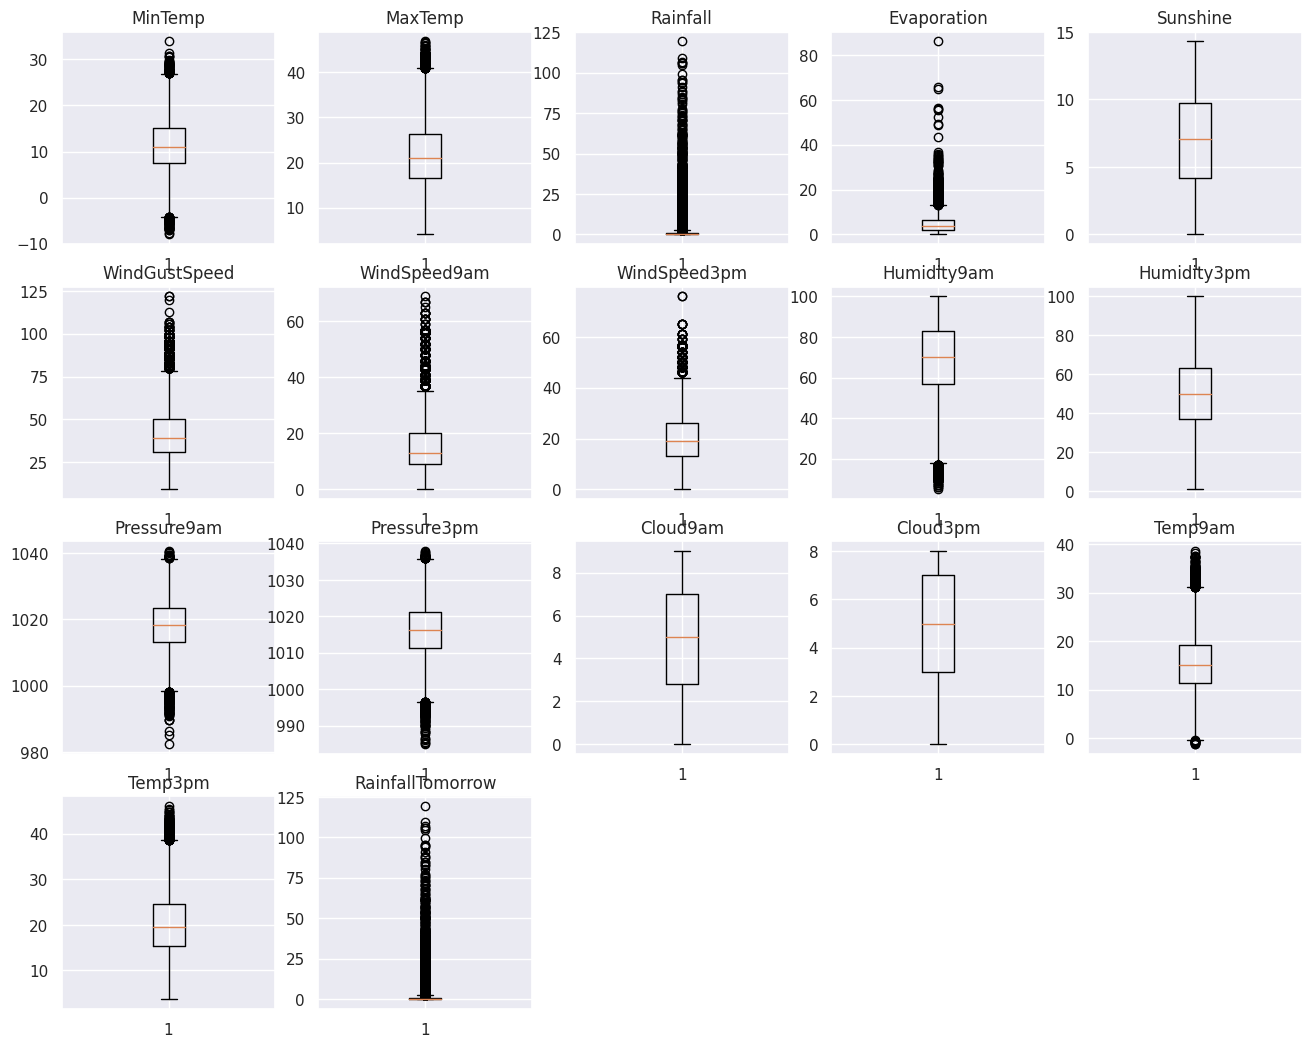

In [46]:
plt.figure(figsize=(16, 16))

for idx, col in enumerate(df_filtrado_numerico.columns[0:17], start=1):
    plt.subplot(5, 5, idx)
    plt.boxplot(df_filtrado[col])
    plt.title(col)

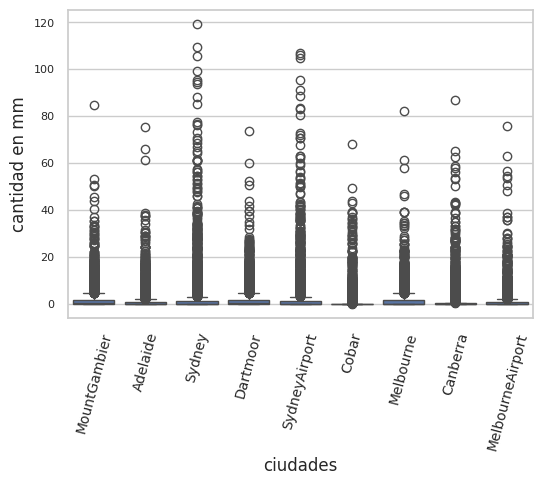

In [47]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
plt.yticks(fontsize=8)
sns.boxplot(x='Location', y='Rainfall', data=df_filtrado)
plt.title('')
plt.xlabel('ciudades')
plt.ylabel('cantidad en mm')
plt.show()

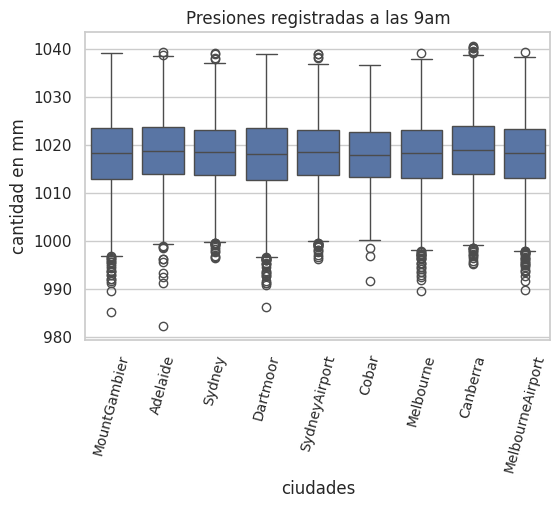

In [48]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
sns.boxplot(x='Location', y='Pressure9am', data=df_filtrado)
plt.title('Presiones registradas a las 9am')
plt.xlabel('ciudades')
plt.ylabel('cantidad en mm')
plt.show()

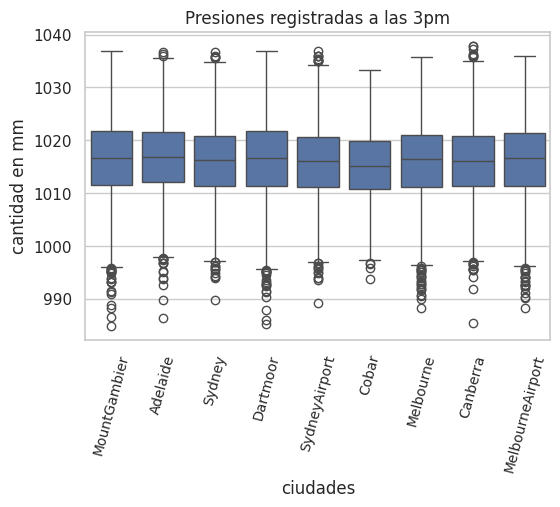

In [49]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
sns.boxplot(x='Location', y='Pressure3pm', data=df_filtrado)
plt.title('Presiones registradas a las 3pm')
plt.xlabel('ciudades')
plt.ylabel('cantidad en mm')
plt.show()

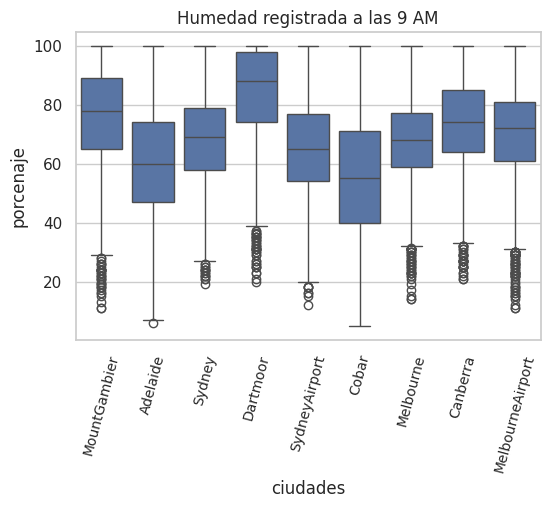

In [50]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
sns.boxplot(x='Location', y= 'Humidity9am', data=df_filtrado)
plt.title('Humedad registrada a las 9 AM' )
plt.xlabel('ciudades')
plt.ylabel('porcenaje')
plt.show()

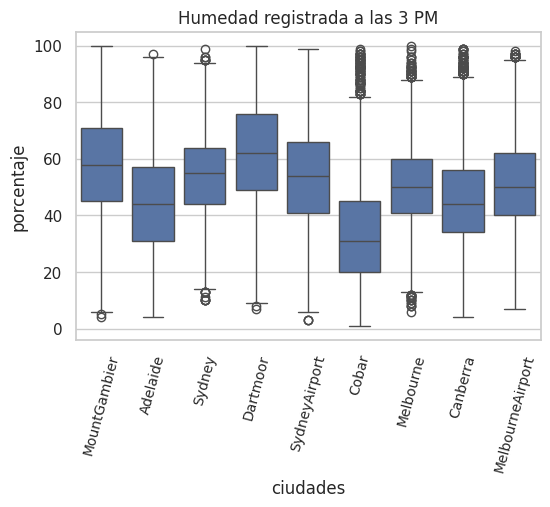

In [51]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
sns.boxplot(x='Location', y='Humidity3pm', data=df_filtrado)
plt.title('Humedad registrada a las 3 PM')
plt.xlabel('ciudades')
plt.ylabel('porcentaje')
plt.show()

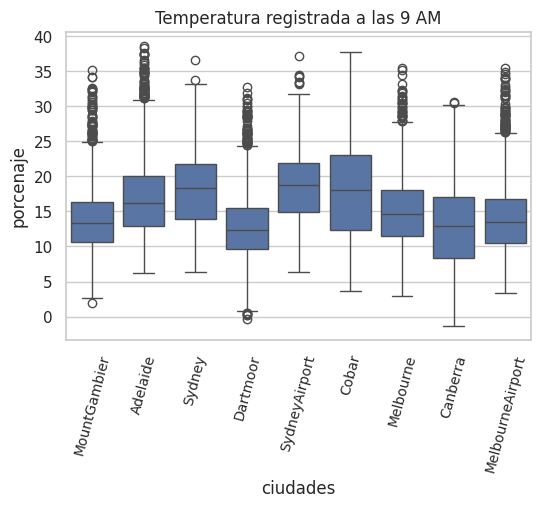

In [52]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
sns.boxplot(x='Location', y= 'Temp9am', data=df_filtrado)
plt.title('Temperatura registrada a las 9 AM' )
plt.xlabel('ciudades')
plt.ylabel('porcenaje')
plt.show()

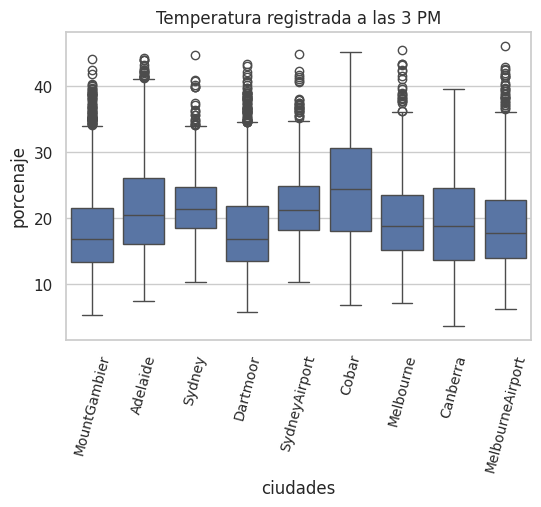

In [53]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
sns.boxplot(x='Location', y= 'Temp3pm', data=df_filtrado)
plt.title('Temperatura registrada a las 3 PM' )
plt.xlabel('ciudades')
plt.ylabel('porcenaje')
plt.show()

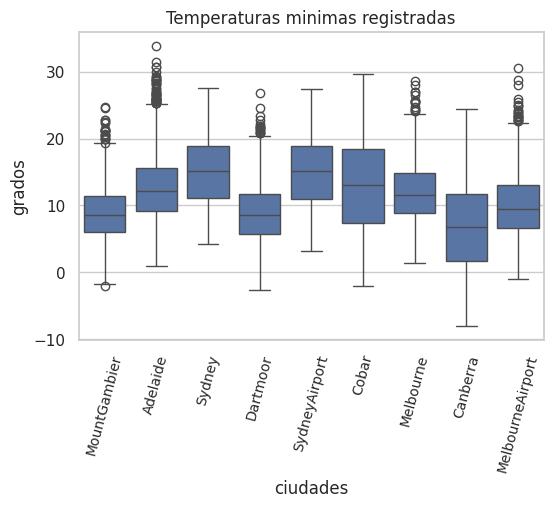

In [54]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
sns.boxplot(x='Location', y= 'MinTemp', data=df_filtrado)
plt.title('Temperaturas minimas registradas')
plt.xlabel('ciudades')
plt.ylabel('grados')
plt.show()

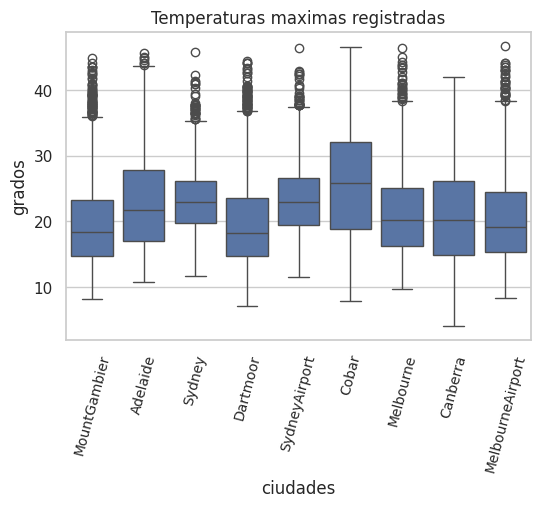

In [55]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75, fontsize=10)
sns.boxplot(x='Location', y= 'MaxTemp', data=df_filtrado)
plt.title('Temperaturas maximas registradas')
plt.xlabel('ciudades')
plt.ylabel('grados')
plt.show()

Decidimos mantener los outliers ya que consideramos que pueden ser casos atipicos puesto que al disciminarlos por ciudad estan presentes en la mayoria.

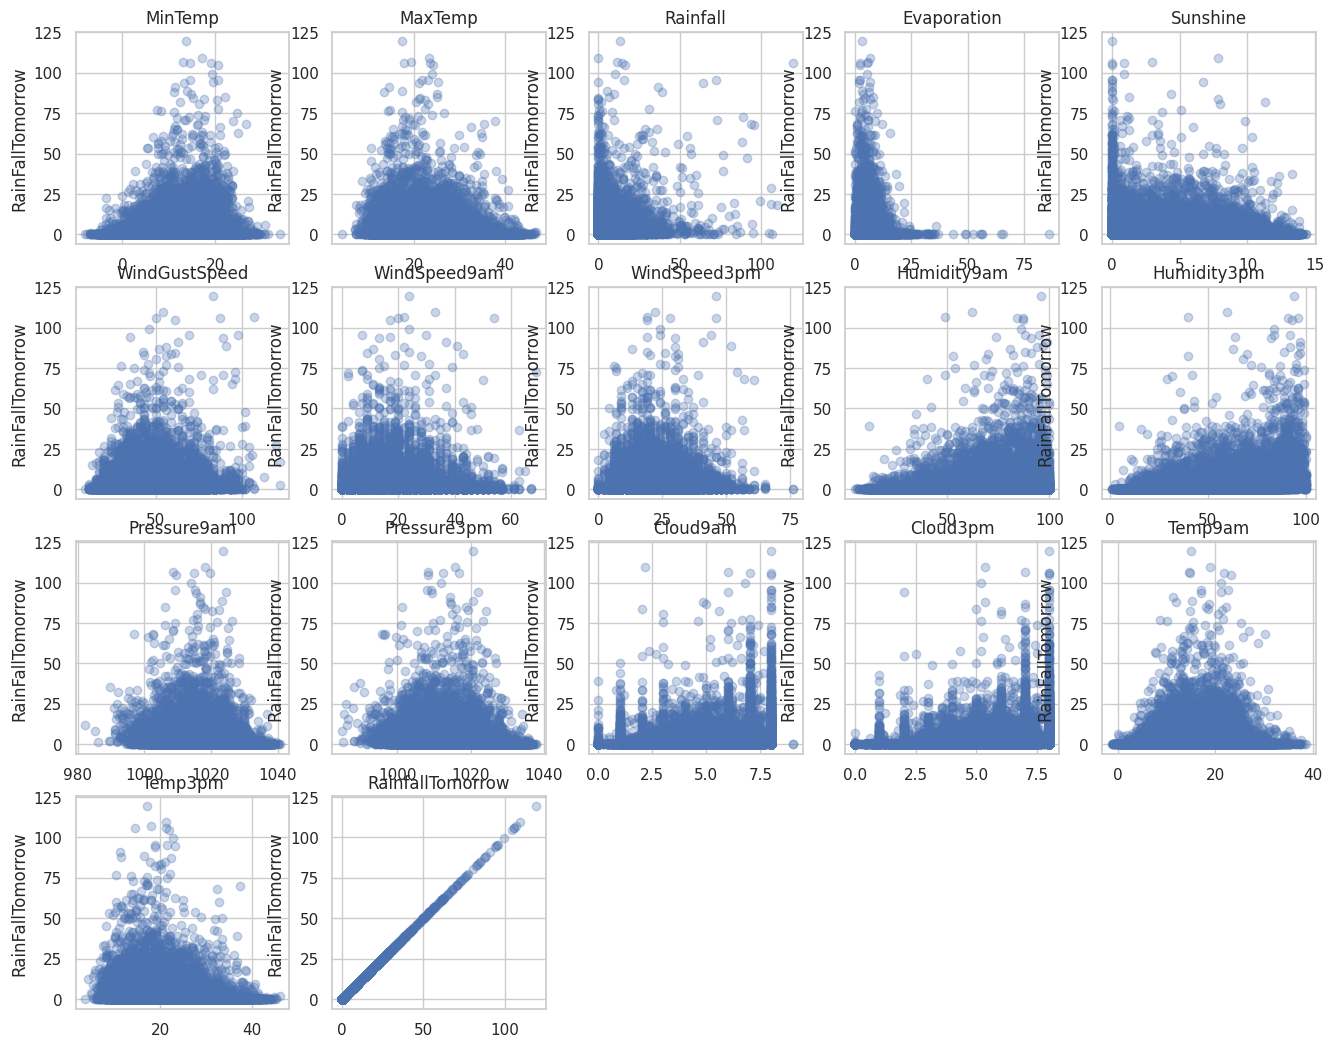

In [56]:
plt.figure(figsize=(16, 16))

for idx, col in enumerate(df_filtrado_numerico.columns[0:17], start=1):
    plt.subplot(5, 5, idx)
    plt.ylabel('RainFallTomorrow')
    plt.scatter(data=df_filtrado, x=col, y='RainfallTomorrow', alpha=.3)
    plt.title(col)

Evaluamos el comportamiento de la variable RainFallTomorrow respecto del resto de las variables cuantitativas, no observamos una correlacion lineal fuerte con ninguna de ellas.  

In [57]:
df_yes_today = df_filtrado[df_filtrado['RainToday'] == 'Yes']
df_no_today = df_filtrado[df_filtrado['RainToday'] == 'No']
df_yes_tomorrow = df_filtrado[df_filtrado['RainTomorrow'] == 'Yes']
df_no_tomorrow = df_filtrado[df_filtrado['RainTomorrow'] == 'No']

In [58]:
rain_today_season = df_yes_today.groupby("season")["RainToday"].count()
no_rain_today_season = df_no_today.groupby("season")["RainToday"].count()
rain_tomorrow_season = df_yes_tomorrow.groupby("season")["RainTomorrow"].count()
no_rain_tomorrow_season = df_no_tomorrow.groupby("season")["RainTomorrow"].count()

In [59]:
rain_today_percent = (rain_today_season /(rain_today_season + no_rain_today_season))*100
no_rain_today_percent = (no_rain_today_season /(rain_today_season + no_rain_today_season))*100
rain_tomorrow_percent = (rain_tomorrow_season /(rain_tomorrow_season + no_rain_tomorrow_season))*100
no_rain_tomorrow_percent = (no_rain_tomorrow_season /(rain_tomorrow_season + no_rain_tomorrow_season))*100

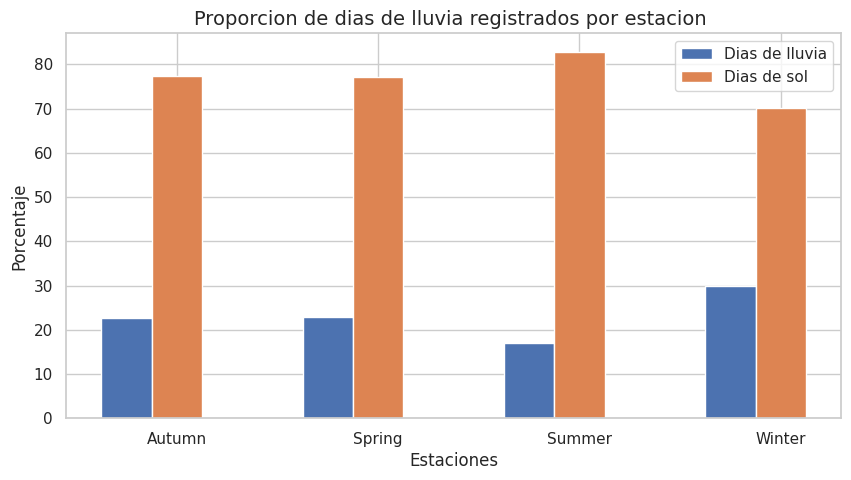

In [60]:
x = np.arange(4)
plt.figure(figsize = (10,5))
plt.title("Proporcion de dias de lluvia registrados por estacion ",fontsize=14)
plt.xlabel("Estaciones", fontsize=12)
plt.ylabel("Porcentaje",fontsize=12)
plt.bar(x -0.25, rain_today_percent, width=0.25,label = 'Dias de lluvia')
plt.bar(x , no_rain_today_percent,width=0.25, label = 'Dias de sol')
plt.xticks(x,rain_today_season.index)
plt.legend()
plt.show()

In [61]:
print("Porcentaje de dias de lluvia por estacion")
print(rain_today_percent.round(2))

Porcentaje de dias de lluvia por estacion
season
Autumn    22.74
Spring    22.91
Summer    17.11
Winter    29.96
Name: RainToday, dtype: float64


In [62]:
dias_por_estacion = 90*(rain_today_percent.round(2)/100)

print("Dias de lluvia por estacion")
print(dias_por_estacion.astype(int))

Dias de lluvia por estacion
season
Autumn    20
Spring    20
Summer    15
Winter    26
Name: RainToday, dtype: int64


En el grafico de barras podemos observar que el invierno tiene el mayor porcentaje de días de precipitaciones, alrededor del 30%, mientras que el verano tiene el porcentaje mas bajo, alrededor del 17%. Las estaciones de otoño y primavera presentan alrededor de un 23% . Esto significa que el invierno registra alrededor de 26 dias de lluvia en un total de 90 dias.Otoño y primavera alrededor de 20 dias y verano registraria aproximadamente 15 dias de lluvia.

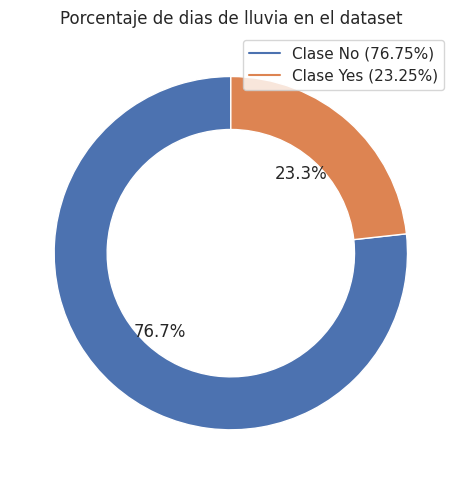

In [63]:
unique, counts = np.unique(df_filtrado['RainTomorrow'], return_counts=True)
porcentajes = (counts / len(df_filtrado['RainTomorrow'])) * 100

plt.figure(figsize=(10, 5))

# Subplot para el primer gráfico
plt.plot(1, 2, 1)
labels = [f'Clase {clase} ({porcentaje:.2f}%)' for clase, porcentaje in zip(unique, porcentajes)]
plt.pie(counts, labels=None, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))
plt.gca().add_artist(plt.Circle((0, 0), 0.2, fc='white'))
plt.title('Porcentaje de dias de lluvia en el dataset')
plt.legend(labels)

plt.tight_layout()
plt.show()

Podemos concluir que el dataset esta desbalanceado para la variable RainTomorrow por lo que deberemos aplicar alguna tecnica de balanceo para el modelo de clasificacion

## Matriz de correlacion

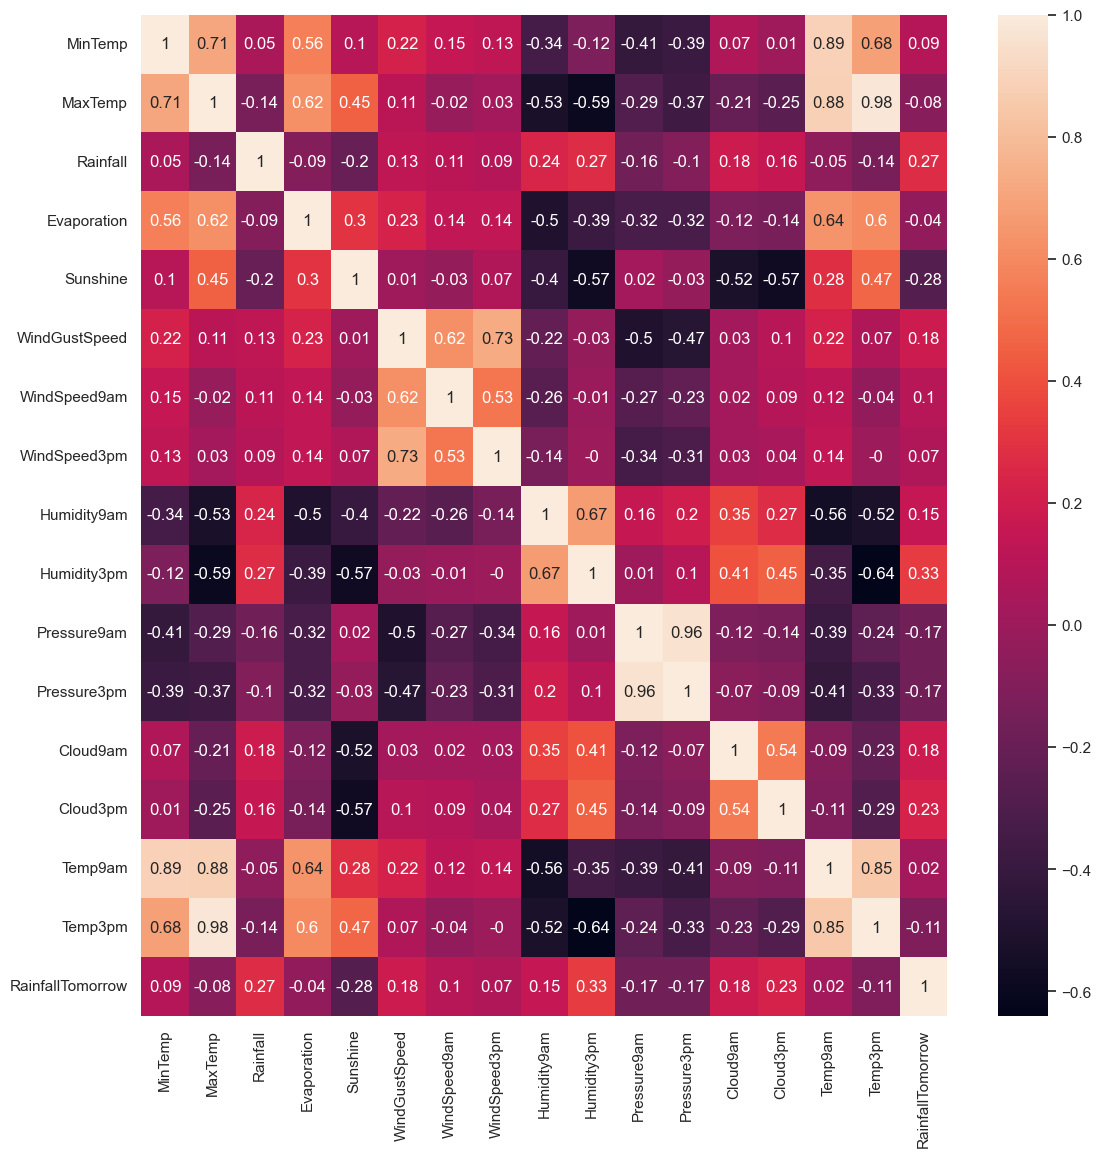

In [ ]:
corr = df_filtrado.drop('WindGustDir', axis=1)\
           .drop('Date', axis = 1)\
           .drop('Location', axis = 1)\
           .drop('WindDir9am', axis = 1)\
           .drop('WindDir3pm', axis = 1)\
           .drop('RainToday', axis = 1)\
           .drop('RainTomorrow', axis = 1)\
           .drop('season', axis = 1)\
           .corr().round(2)

plt.figure(figsize = (13,13   ))
sns.heatmap(corr, annot=True)
plt.show()

Las variables con mayor correlacion lineal positiva;

*   MaxTemp - Temp3pm (0.98)
*   Pressure - Pressure3pm (0.96)
*   MinTemp - Temp9am (0.89)
*   MaxTemp - Temp9pm (0.88)
*   WindGustSpeed - WindSpeed3pm (0.73)
*   Evaporation - Temp9pm (0.64)

Las variables con mayor correlacion lineal negativa son:

*   Humidity3pm - Temp3pm (-0.64)
*   MaxTemp - Humidity3pm (-0.59)
*   Sunshine - Humidity3pm (-0.57)   
*   Sunshine - Cloud3pm (-0.57)  


## Codificacion de variables categoricas

In [65]:
df_train['WindGustDir'].unique()

array(['SW', 'S', 'SSW', 'W', 'SSE', 'E', 'SE', 'NE', 'NNE', 'WSW', 'WNW',
       'NW', 'N', 'ESE', 'ENE', 'NNW'], dtype=object)

In [66]:
df_train_codificado = codificar_variables(df_train)

In [67]:
df_train_codificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21658 entries, 0 to 21657
Data columns (total 75 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MinTemp                    21658 non-null  float64
 1   MaxTemp                    21658 non-null  float64
 2   Rainfall                   21658 non-null  float64
 3   Evaporation                21658 non-null  float64
 4   Sunshine                   21658 non-null  float64
 5   WindGustSpeed              21658 non-null  float64
 6   WindSpeed9am               21658 non-null  float64
 7   WindSpeed3pm               21658 non-null  float64
 8   Humidity9am                21658 non-null  float64
 9   Humidity3pm                21658 non-null  float64
 10  Pressure9am                21658 non-null  float64
 11  Pressure3pm                21658 non-null  float64
 12  Cloud9am                   21658 non-null  float64
 13  Cloud3pm                   21658 non-null  flo

In [68]:
df_test_codificado = codificar_variables(df_test)

In [69]:
df_test_codificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5414 entries, 21658 to 27071
Data columns (total 75 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MinTemp                    5414 non-null   float64
 1   MaxTemp                    5414 non-null   float64
 2   Rainfall                   5414 non-null   float64
 3   Evaporation                5414 non-null   float64
 4   Sunshine                   5414 non-null   float64
 5   WindGustSpeed              5414 non-null   float64
 6   WindSpeed9am               5414 non-null   float64
 7   WindSpeed3pm               5414 non-null   float64
 8   Humidity9am                5414 non-null   float64
 9   Humidity3pm                5414 non-null   float64
 10  Pressure9am                5414 non-null   float64
 11  Pressure3pm                5414 non-null   float64
 12  Cloud9am                   5414 non-null   float64
 13  Cloud3pm                   5414 non-null   

**VALIDACION TRAIN-TEST**

In [70]:
# Dividir el conjunto de datos de entrenamiento en características (X) y variables objetivo (y)
X_train_regresion = df_train_codificado.drop(columns=['RainfallTomorrow'])
X_train_clasificacion = df_train_codificado.drop(columns=['RainTomorrow_Yes', "RainfallTomorrow"])

y_train_rainfall_tomorrow = df_train_codificado['RainfallTomorrow']
y_train_rain_tomorrow = df_train_codificado['RainTomorrow_Yes']

In [71]:
# Dividir el conjunto de datos de test en características (X) y variables objetivo (y)
X_test_regresion = df_test_codificado.drop(columns=['RainfallTomorrow'])
X_test_clasificacion = df_test_codificado.drop(columns=['RainTomorrow_Yes', "RainfallTomorrow"])

y_test_rain_tomorrow = df_test_codificado['RainTomorrow_Yes']
y_test_rainfall_tomorrow = df_test_codificado['RainfallTomorrow']

## Estandarizacion

In [72]:
#Utilizamos RobustScaler porque es menos sensible a los valores atipicos.
scaler = RobustScaler()

In [73]:
X_train_scaled=scaler.fit_transform(X_train_regresion)
X_test_scaled=scaler.transform(X_test_regresion)

y_train_scaled = scaler.fit_transform(y_train_rainfall_tomorrow.values.reshape(-1,1))
y_test_scaled = scaler.fit_transform(y_test_rainfall_tomorrow.values.reshape(-1,1))

In [74]:
X_train_scaled1=scaler.fit_transform(X_train_clasificacion)
X_test_scaled1=scaler.transform(X_test_clasificacion)

y_train_scaled1 = scaler.fit_transform(y_train_rain_tomorrow.values.reshape(-1,1))
y_test_scaled1 = scaler.fit_transform(y_test_rain_tomorrow.values.reshape(-1,1))

In [75]:
X_train_scaled

array([[ 0.24675325, -0.4       ,  0.8       , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.80519481,  0.22105263,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  1.46315789,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.88311688,  0.83157895,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.1038961 , -0.31578947,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.62337662,  0.46315789,  0.4       , ...,  0.        ,
         0.        ,  0.        ]])

In [76]:
X_train_scaled1

array([[ 0.24675325, -0.4       ,  0.8       , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.80519481,  0.22105263,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  1.46315789,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.88311688,  0.83157895,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.1038961 , -0.31578947,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.62337662,  0.46315789,  0.4       , ...,  0.        ,
         0.        ,  0.        ]])

### Metricas

In [77]:
def metricas_regresion(y, y_pred):
    print('R2:   %.2f' % r2_score(y, y_pred))
    print('MSE:  %.2f' % mean_squared_error(y, y_pred))
    print('MAE:  %.2f' % mean_absolute_error(y, y_pred))

In [78]:
def metricas_regresion_comparar(y, y_pred):
    print('MSE:  %.2f' % mean_squared_error(y, y_pred))
    print('MAE:  %.2f' % mean_absolute_error(y, y_pred))

In [79]:
def metricas_clasificacion(y, y_pred):
  accuracy = log_loss(y, y_pred)
  recall = recall_score(y, y_pred)
  precision = precision_score(y, y_pred)
  classificacion_report = classification_report(y, y_pred)

  # Imprimir métricas
  print('Logloss:%.2f' %(accuracy))
  print("Reporte de clasificación:")
  print(classificacion_report)
  return recall, precision

In [80]:
def metricas_clasificacion_comparar(y, y_pred):
    print('Precision:  %.2f' % precision_score(y_pred, y))


## Regresion Lineal

In [ ]:
def gradient_descent(X_train, y_train, X_test, y_test, lr, epochs):

    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de test')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    print("MSE de train :", train_mse)
    print("MSE de test :", test_mse)
    return

In [ ]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr, epochs, batch_size=1000):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):

        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    print("MSE de train :", train_mse)
    print("MSE de test :", test_mse)
    return

In [ ]:
regresion = LinearRegression()
regresion.fit(X_train_scaled,y_train_scaled)

LinearRegression()

In [ ]:
y_pred_regresion_train = regresion.predict(X_train_scaled)
y_pred_regresion = regresion.predict(X_test_scaled)

print("Metricas de train")
print(metricas_regresion(y_train_scaled, y_pred_regresion_train))
print("Metricas de test")
print(metricas_regresion(y_test_scaled, y_pred_regresion))

Metricas de train
R2:   0.35
MSE:  24.83
MAE:  2.11
None
Metricas de test
R2:   0.38
MSE:  28.11
MAE:  2.26
None


 R2 nos da 0.38, es decir que solo pueden llegar a explicar un 38% de la variabilidad de los datos.

 MSE es similar a la medida estadística de varianza que nos permite medir la incertidumbre alrededor de nuestro más probable pronóstico.En nuestro caso es de 28.11, por lo tanto la incertidumbre en el resultado es de 28,1 mm.

 El error absoluto medio(MAE) es una medida común del error de pronóstico en análisis de series de tiempo, nos da 2,26.



## Gradiente Descendiente

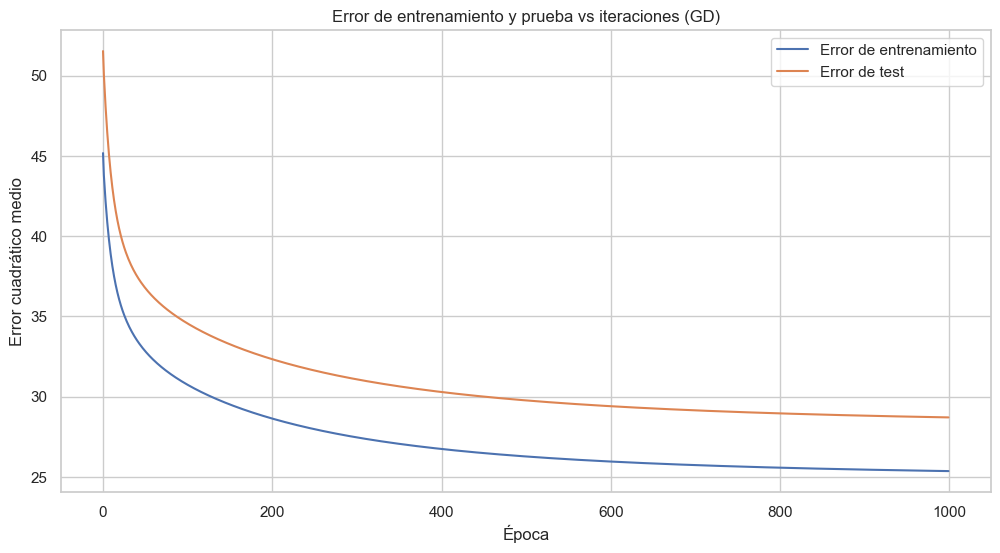

MSE de train : 25.360325428493038
MSE de test : 28.70448740790674


In [ ]:
gradient_descent(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, lr=0.01, epochs=1000)

### Gradiente Descendiente Estocastico

In [ ]:
gradiente = SGDRegressor()
gradiente.fit(X_train_scaled, y_train_scaled)

SGDRegressor()

In [ ]:
y_pred_gradiente_train = gradiente.predict(X_train_scaled)
y_pred_gradiente_test = gradiente.predict(X_test_scaled)

print("Metricas de train")
print(metricas_regresion(y_train_scaled, y_pred_gradiente_train))
print("Metricas de test")
print(metricas_regresion(y_test_scaled, y_pred_gradiente_test))

Metricas de train
R2:   0.29
MSE:  27.17
MAE:  2.10
None
Metricas de test
R2:   0.29
MSE:  31.87
MAE:  2.27
None


### Gradiente Descendiente (Mini_batch)

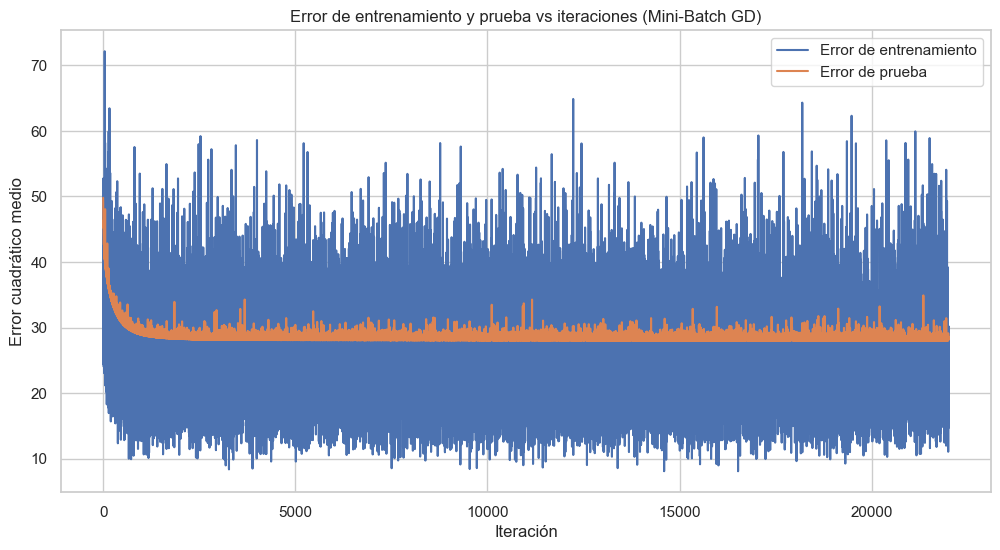

MSE de train : 20.55048201866486
MSE de test : 28.27301955193033


In [ ]:
mini_batch_gradient_descent(X_train_scaled, y_train_scaled,\
                            X_test_scaled, y_test_scaled,lr=0.01,\
                            epochs=1000)


## Metodos de regularizacion

## RidgeCV

In [ ]:
ridge = RidgeCV()
ridge.fit(X_train_scaled, y_train_scaled)

RidgeCV()

In [ ]:
y_pred_ridge_train = ridge.predict(X_train_scaled)
y_pred_ridge_test = ridge.predict(X_test_scaled)

print("Metricas de train")
print(metricas_regresion(y_train_scaled, y_pred_ridge_train))
print("Metricas de test")
print(metricas_regresion(y_test_scaled, y_pred_ridge_test))

Metricas de train
R2:   0.35
MSE:  24.83
MAE:  2.10
None
Metricas de test
R2:   0.38
MSE:  28.12
MAE:  2.26
None


## LassoCV

In [ ]:
lasso = LassoCV()
lasso.fit(X_train_scaled, y_train_scaled)

LassoCV()

In [ ]:
y_pred_lasso_train = lasso.predict(X_train_scaled)
y_pred_lasso_test = lasso.predict(X_test_scaled)

print("Metricas de train")
print(metricas_regresion(y_train_scaled, y_pred_lasso_train))
print("Metricas de test")
print(metricas_regresion(y_test_scaled, y_pred_lasso_test))

Metricas de train
R2:   0.35
MSE:  24.93
MAE:  2.03
None
Metricas de test
R2:   0.37
MSE:  28.28
MAE:  2.17
None


### ElasticNetCV

In [ ]:
elastic = ElasticNetCV()
elastic.fit(X_train_scaled, y_train_scaled)

ElasticNetCV()

In [ ]:
y_pred_elastic_train = elastic.predict(X_train_scaled)
y_pred_elastic_test = elastic.predict(X_test_scaled)

print("Metricas de train")
print(metricas_regresion(y_train_scaled, y_pred_elastic_train))
print("Metricas de test")
print(metricas_regresion(y_test_scaled, y_pred_elastic_test))

Metricas de train
R2:   0.35
MSE:  25.03
MAE:  2.00
None
Metricas de test
R2:   0.37
MSE:  28.51
MAE:  2.15
None


De los cuatro modelos lineales que probamos vemos que Lasso y ElasticNet nos dan un R2 de 0.37, es decir que solo pueden llegar a explicar un 37% de la variabilidad de los datos.
En cuanto a MSE que es la metrica que vamos a usar para comparar los modelos en conjunto  de test, la Regresion tiene la metrica mas baja 28.11.

Aunque  todos los modelos tienen valores muy cercanos.

## Modelo de clasificacion

### Regresion logistica

In [81]:
# Se define el modelo de Regresión Logística, se entrena el modelo y se prueba
#random_state produce el mismo resultado en diferentes llamadas
#class_weight = 'balanced' ajusta los pesos inversamente proporcional a la frecuencia de la clase
logreg = LogisticRegression(random_state=42,class_weight='balanced')


In [82]:
logreg.fit(X_train_scaled1, y_train_scaled1)

LogisticRegression(class_weight='balanced', random_state=42)

In [83]:
#Predicciones en conjuntos de train y test
y_pred_logreg_train = logreg.predict(X_train_scaled1)
y_pred_logreg_test = logreg.predict(X_test_scaled1)

### Metricas para evaluar modelos de clasificacion:

**Perdida logaritmica:**

Es una metrica de clasificacion basada en probabilidades.A medida que la probabilidad de la clase verdadera se acerca a cero, la perdida aumenta exponencialmente..

Mide el desempeño de un modelo de clasificacion en el que la entrada de la prediccion es un valor de probabilidad entre 0 y 1.La perdida logaritmica aumente a medida que la probabilidad predicha se aleja de la etiqueta real

**Precision:**

La métrica de precisión es utilizada para poder saber qué porcentaje de valores que se han clasificado como positivos son realmente positivos.

**Recall:**

La métrica de recall, también conocida como el ratio de verdaderos positivos, es utilizada para saber cuantos valores positivos son correctamente clasificados.

**f1_score:**

Esta es una métrica muy utilizada en problemas en los que el conjunto de datos a analizar está desbalanceado. Esta métrica combina el precision y el recall, para obtener un valor mucho más objetivo.

In [84]:
print("Metricas de train")
recall_train, precision_train = metricas_clasificacion(y_train_scaled1, y_pred_logreg_train)

Metricas de train
Logloss:7.38
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.92      0.80      0.86     16618
         1.0       0.54      0.78      0.64      5040

    accuracy                           0.80     21658
   macro avg       0.73      0.79      0.75     21658
weighted avg       0.83      0.80      0.81     21658



In [85]:
print("Metricas de test")
recall_test, precision_test = metricas_clasificacion(y_test_scaled1, y_pred_logreg_test)

Metricas de test
Logloss:7.32
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86      4159
         1.0       0.54      0.77      0.64      1255

    accuracy                           0.80      5414
   macro avg       0.73      0.79      0.75      5414
weighted avg       0.83      0.80      0.81      5414



Elegimos estás métricas ya que queremos predecir si llueve mañana, y cuan exacta es esa predicción.

Es decir , detecta la clase "lluvia_mañana_si" en el 77% de los casos y cuando lo hace tiene una confiabilidad del 54%.

f1_score es 0.64 media armonica entre precision y recall.

La perdida logaritmica es 7.38, es decir, la probabilidad es cercana a la etiqueta real.

**Matriz de confusion**

Matriz de entrenamiento


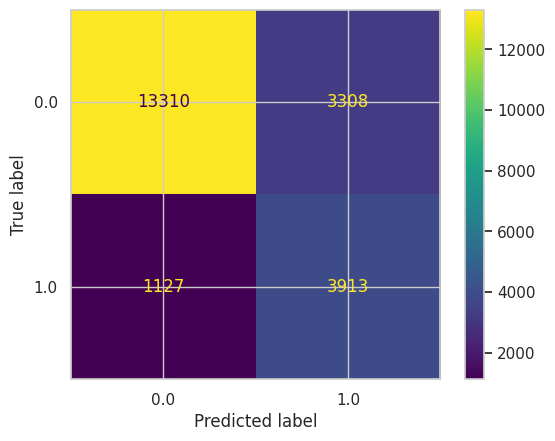

In [86]:
print("Matriz de entrenamiento")
_ = ConfusionMatrixDisplay.from_estimator(logreg, X_train_scaled1, y_train_scaled1)



FP (False Positive): 3308(Casos incorrectamente clasificados como positivos, es decir, falsas alarmas de lluvia).

FN (False Negative): 1127(Casos incorrectamente clasificados como negativos, es decir, lluvia no detectada)

Matriz de test


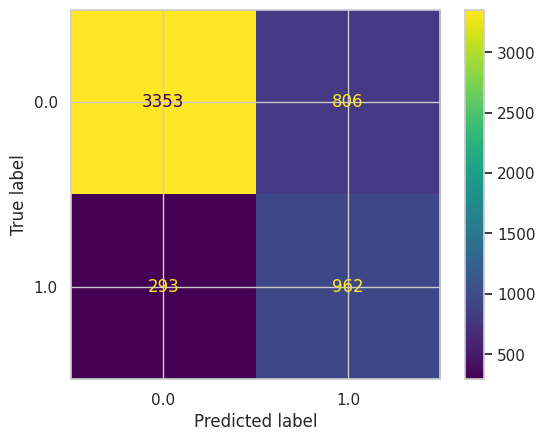

In [87]:
print("Matriz de test")
_ = ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled1, y_test_scaled1)

Falsos Positivos (FP): 806 Son los casos en los que el modelo predijo incorrectamente que llovería (clase "True") cuando en realidad no llovió.

Falsos Negativos (FN): 293 Son los casos en los que el modelo predijo incorrectamente que no llovería (clase "False") cuando en realidad llovió.

**Curva ROC**

In [88]:
# Obtengo las probabilidades de predicción de train
y_probs = logreg.predict_proba(X_train_clasificacion)[:, 1]

#Calculo la ROC y el AUC
fpr1, tpr1, thresholds1 = roc_curve(y_train_rain_tomorrow, y_probs)
roc_auc1 = auc(fpr1, tpr1)

# Obtengo las probabilidades de predicción de test
y_probs_test = logreg.predict_proba(X_test_clasificacion)[:, 1]

# Calculo la ROC y el AUC
fpr2, tpr2, thresholds2 = roc_curve(y_test_rain_tomorrow, y_probs_test)
roc_auc2 = auc(fpr2, tpr2)

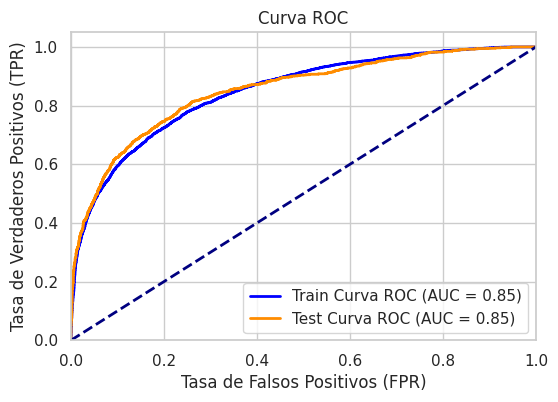

In [89]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr1, tpr1, color='blue', lw=2, label='Train Curva ROC (AUC = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label='Test Curva ROC (AUC = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Por lo general, lo que buscamos es un clasificador que mantenga una alta tasa de verdaderos positivos y al mismo tiempo tenga una baja tasa de falsos positivos; este clasificador ideal tendería a pasar muy próximo a la esquina superior izquierda de la figura

**Indice de Youden** (o estadística J de Youden):
 se utiliza para seleccionar el corte de probabilidad pronosticado óptimo. Es la distancia vertical máxima entre la curva ROC y la línea diagonal, donde la idea es maximizar la diferencia entre la tasa de verdaderos positivos y la tasa de falsos positivos.

**Indice de Youden(J)** = Sensitivity - (1-Specificity) = Recall - (1 - Precision)

In [ ]:
J_train = recall_train - (1 - precision_train)
J_test = recall_test - (1 - precision_test)

print("Indice de Jouden para train:", J_train.round(2))
print("Indice de Jouden para test:", J_test.round(2))

Indice de Jouden para train: 0.32
Indice de Jouden para test: 0.31


Calculando el indice de Youden, un punto de corte optimo seria 0.31.

AUC = 0.85, nos indica que tiene un buen desempeño del clasificador, ya que su valor maximo es 1(clasificacion perfecta)

Para la clase "True" ("lluvia_mañana_si):

La precisión es 0.54, lo que significa que el 54% de las veces que el modelo predijo "lluvia", estas predicciones fueron correctas.

El recall es del 0.77, lo que significa que el 77% de las veces, el modelo identificó la clase positiva.

La perdida logaritmica es 7.32 ,baja, es decir, la probabilidad predicha esta cerca de la etiquet real.

En el conjunto de test se mantiene un recall y una precision similar al de train.

El f1-score es 0.64 tambiien se mantiene igual al train.



Falsos Positivos (FP): 806
Son los casos en los que el modelo predijo incorrectamente que llovería (clase "True") cuando en realidad no llovió.

Falsos Negativos (FN): 293
Son los casos en los que el modelo predijo incorrectamente que no llovería (clase "False") cuando en realidad llovió.

### Regresion logistica con SMOTE

In [90]:
#Modelo de clasificacion con SMOTHE
reglog_smote = LogisticRegression(random_state=42)
smote = SMOTE(random_state=42)

X_smote_train, y_smote_train= smote.fit_resample(X_train_scaled1, y_train_scaled1)
X_smote_test, y_smote_test = smote.fit_resample(X_test_scaled1, y_test_scaled1)

reglog_smote.fit(X_smote_train, y_smote_train)

LogisticRegression(random_state=42)

In [91]:
y_pred_smote_train = reglog_smote.predict(X_smote_train)
y_pred_smote_test = reglog_smote.predict(X_smote_test)

In [92]:
print("Metricas de train")
recall_train, precision_train = metricas_clasificacion(y_smote_train, y_pred_smote_train)

Metricas de train
Logloss:7.18
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.80      0.81      0.80     16618
         1.0       0.80      0.80      0.80     16618

    accuracy                           0.80     33236
   macro avg       0.80      0.80      0.80     33236
weighted avg       0.80      0.80      0.80     33236



In [93]:
print("Metricas de test")
recall_test, precision_test = metricas_clasificacion(y_smote_test, y_pred_smote_test)

Metricas de test
Logloss:7.35
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80      4159
         1.0       0.81      0.78      0.79      4159

    accuracy                           0.80      8318
   macro avg       0.80      0.80      0.80      8318
weighted avg       0.80      0.80      0.80      8318



Matriz de train


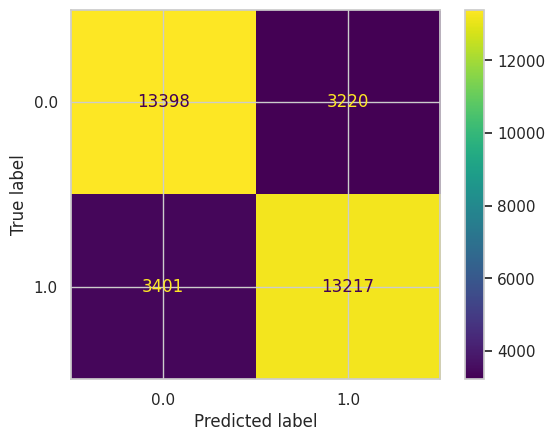

In [94]:
print("Matriz de train")
_ = ConfusionMatrixDisplay.from_estimator(reglog_smote, X_smote_train, y_smote_train)

Matriz de test


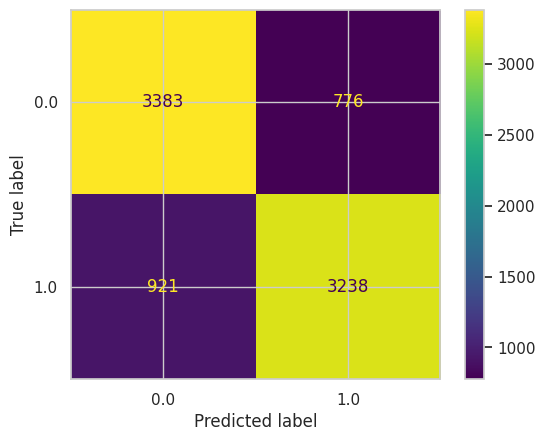

In [95]:
print("Matriz de test")
_ = ConfusionMatrixDisplay.from_estimator(reglog_smote, X_smote_test, y_smote_test)

Aplicando SMOTE al modelo de clasificacion para balancear el dataset, las metricas mejorar dando un f1_score de 0.79 en test, mayor al 0.64 cuando balanceamos con parametro del modelo de regresion logistica.

### MODELO BASE

### Regresion lineal

Vamos a predecir los milimetros de lluvia que caeran mañana, teniendo en cuenta la humedad a las 3pm,utilizando una regresion lineal simple.

In [ ]:
df_train_codificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21658 entries, 0 to 21657
Data columns (total 75 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MinTemp                    21658 non-null  float64
 1   MaxTemp                    21658 non-null  float64
 2   Rainfall                   21658 non-null  float64
 3   Evaporation                21658 non-null  float64
 4   Sunshine                   21658 non-null  float64
 5   WindGustSpeed              21658 non-null  float64
 6   WindSpeed9am               21658 non-null  float64
 7   WindSpeed3pm               21658 non-null  float64
 8   Humidity9am                21658 non-null  float64
 9   Humidity3pm                21658 non-null  float64
 10  Pressure9am                21658 non-null  float64
 11  Pressure3pm                21658 non-null  float64
 12  Cloud9am                   21658 non-null  float64
 13  Cloud3pm                   21658 non-null  flo

In [ ]:
df_train_codificado[["Humidity3pm", "RainfallTomorrow"]].head(5)

,Humidity3pm,RainfallTomorrow
0,43.000,0.000
1,40.000,0.000
2,22.000,0.000
3,28.875,0.175
4,13.000,0.000


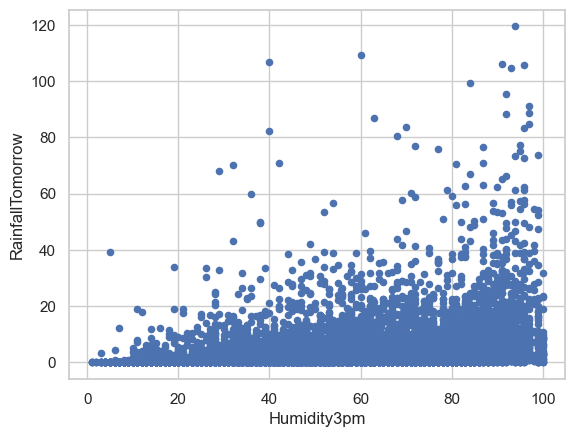

In [ ]:
df_train_codificado.plot.scatter(x="Humidity3pm", y="RainfallTomorrow")
plt.show()

In [ ]:
X_train_base = X_train_regresion["Humidity3pm"]
X_test_base = X_test_regresion["Humidity3pm"]

In [ ]:
X_train_base_scaled = np.array( scaler.fit_transform(X_train_base.values.reshape(-1,1)))
X_test_base_scaled = np.array(scaler.fit_transform(X_test_base.values.reshape(-1,1)))

In [ ]:
regresion_base = LinearRegression()

In [ ]:
regresion_base.fit(X_train_base_scaled,y_train_scaled)

LinearRegression()

In [ ]:
y_pred_base_train = regresion_base.predict(X_train_base_scaled)
y_pred_base_test = regresion_base.predict(X_test_base_scaled)

print("Metricas de train")
print(metricas_regresion(y_train_scaled, y_pred_base_train))
print("Metricas de test")
print(metricas_regresion(y_test_scaled, y_pred_base_test))

Metricas de train
R2:   0.10
MSE:  34.34
MAE:  2.80
None
Metricas de test
R2:   0.11
MSE:  40.22
MAE:  2.98
None


El modelo solo explica el 10% de la variabilidad de los datos.
El MSE mide el error cuadratico medio de los errores al cuadrado, es decir la diferencia entre el valor predicho y el esperado.
En este modelo nos da 40.22, mayor al valor del modelo  de regresion lineal multiple.

### Clasificacion

Naive Bayes es una técnica de clasificación estadística basada en el Teorema de Bayes. Es uno de los algoritmos de aprendizaje supervisado más sencillos.

El clasificador Naive Bayes asume que el efecto de una característica concreta en una clase es independiente de otras características.

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train_scaled1, y_train_scaled1)


GaussianNB()

In [ ]:
y_pred_gnb_train = gnb.predict(X_train_scaled1)
y_pred_gnb_test = gnb.predict(X_test_scaled1)

print("Metricas de train")
print(metricas_clasificacion(y_train_scaled1, y_pred_gnb_train), "\n")
print("Metricas de test")
print(metricas_clasificacion(y_test_scaled1, y_pred_gnb_test))

Metricas de train
Logloss:9.91
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.88      0.74      0.80     16618
         1.0       0.44      0.68      0.54      5040

    accuracy                           0.73     21658
   macro avg       0.66      0.71      0.67     21658
weighted avg       0.78      0.73      0.74     21658

(0.6837301587301587, 0.44145529080194723) 

Metricas de test
Logloss:9.67
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.88      0.75      0.81      4159
         1.0       0.45      0.65      0.53      1255

    accuracy                           0.73      5414
   macro avg       0.66      0.70      0.67      5414
weighted avg       0.78      0.73      0.75      5414

(0.6549800796812749, 0.44625407166123776)


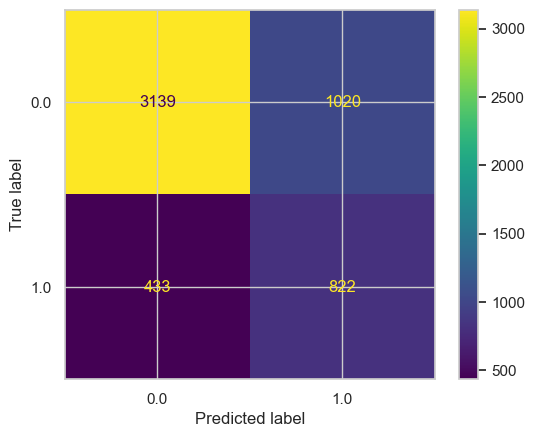

In [ ]:
_ = ConfusionMatrixDisplay.from_estimator(gnb, X_test_scaled1, y_test_scaled1)

## **Explicabilidad**

**SHAP** nos proporciona una forma de entender que variables están impulsando las predicciones del modelo y cómo contribuyen a la predicción. Esto es valioso porque además de conocer que características son las mas importantes para cada modelo, también podemos ver como interactuan y afectan al resultado final de las predicciones.

EXPLICABILIDAD DEL MODELO de REGRESION

In [ ]:
feature_names1= X_train_regresion.columns.values

In [ ]:
# Crea un objeto explainer SHAP
explainer = shap.LinearExplainer(regresion, X_train_scaled, feature_names = feature_names1)

In [ ]:
# Calcula los valores SHAP para el conjuno  de prueba
shap_values = explainer(X_test_scaled)

In [ ]:
shap_values.shape

(5414, 74)

In [ ]:
#valor base
explainer.expected_value

1.8847320608405824

INTERPRETABILIDAD LOCAL

In [ ]:
index=0

In [ ]:
#prediccion de una instancia
regresion.predict(X_test_scaled)[index]

array([2.57074342])

In [ ]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names1)

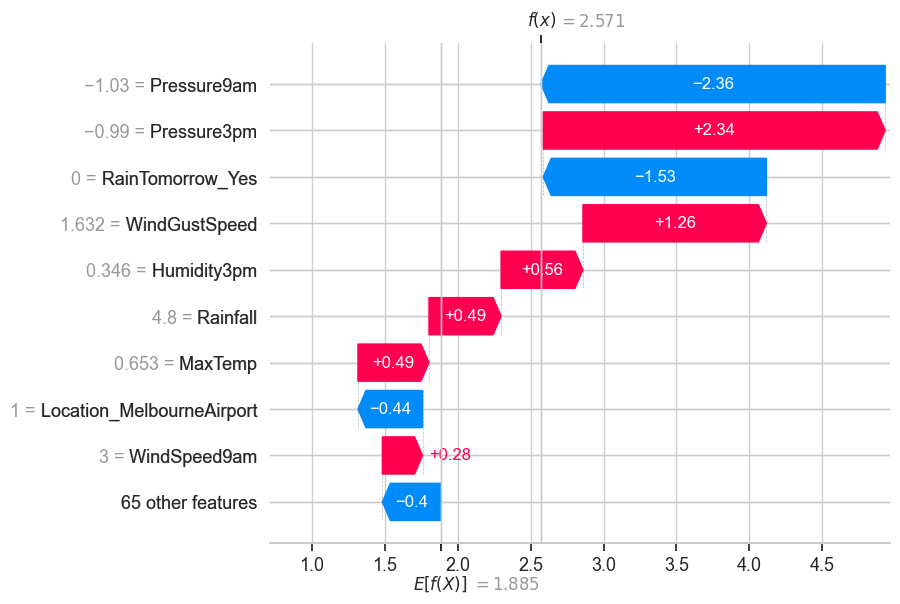

In [ ]:
shap.plots.waterfall(explanation, max_display=10)

El valor base es = 1.8847.
La prediccion de la variable RainfallTomorrow de una instancia se calcula f(x) = 1.8847 + sum(SHAP values)

En la grafica observamos flechas sobre las cuales, se encuentran las cantidades y marcan la direccion en la que cada  variable impacta en la prediccion de la target.

Observamos que entre las variables que mayor contribuyen estan:
positivamente:  **Pressure3am, WindGustSpeed, Humidity3pm, Rainfall, MaxTemp**

negativamente:**Pressure9am,  RainTomorrow_Yes, Location_MelbourneAirport**

En la instancia considerada f(x) = 2.571

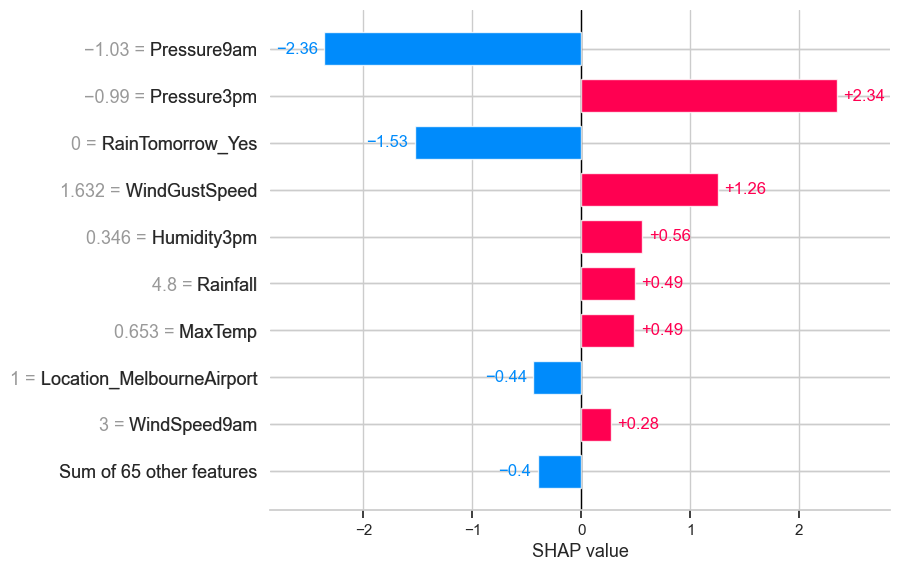

In [ ]:
shap.plots.bar(explanation)

En esta grafica, se observa claramente que las variables **Pressure9am, RainTomorrow_Yes y Location_MelbourneAirport** imprimen una fuerza negativa sobre el valor base.
**Pressure3am, WindGustSpeed, Humidity3pm, Rainfall, MaxTemp y WindSpeed9am** imprimen una fuerza positiva sobre el valor base.

Es decir las fuerzas positivas contribuyen a la cantidad de lluvia caida.   

INTEPRETABILIDAD GLOBAL REGRESION

In [ ]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names1, data=X_test_scaled)

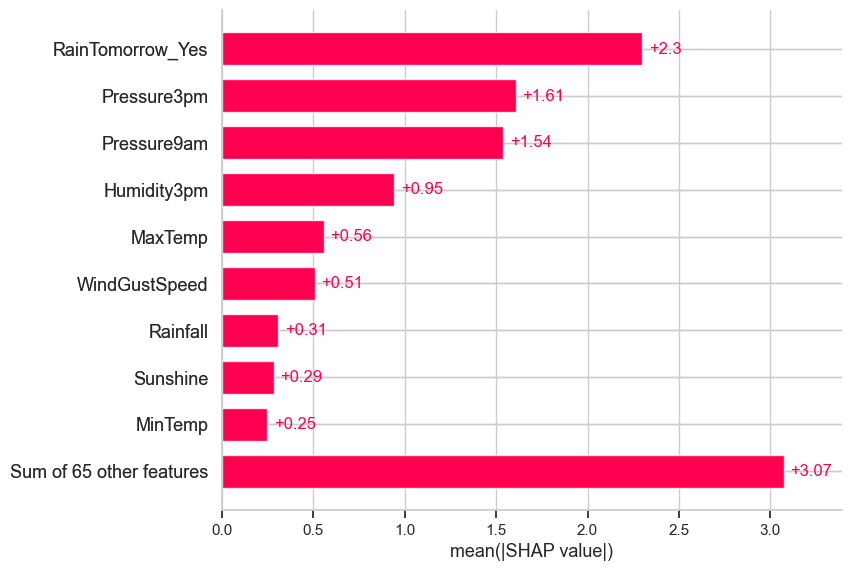

In [ ]:
shap.plots.bar(explanation)

En este grafico de barras, estan representadas las medias absolutas de los SHAP values, donde de mayor a menor, esa magnitud en valor absoluto refleja el impacto en la predicion para todas las instancias.

RainTomorrow_Yes, Pressure3pm, Pressure9am, Humidity3pm, MaxTemp y WindGustSpeed son las mas preponderantes.

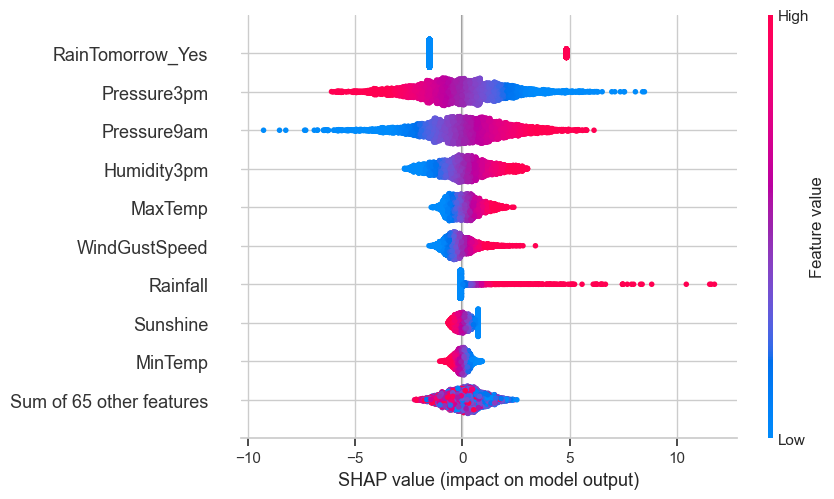

In [ ]:
shap.plots.beeswarm(explanation)

EXPLICABILIDAD DEL MODELO DE CLASIFICACION (SHAP)

In [ ]:
feature_names= X_train_clasificacion.columns.values


In [ ]:
# Crea un objeto explainer SHAP
explainer = shap.LinearExplainer(logreg, X_train_scaled1, feature_names=feature_names)

In [ ]:
# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer(X_test_scaled1)

In [ ]:
shap_values.shape

(5414, 73)

In [ ]:
# valor base
explainer.expected_value

-0.5446720393448833

INTERPRETABILIDAD LOCAL DE CLASIFICACION

In [ ]:
index=0

In [ ]:
logreg.predict_proba(X_test_scaled1)[index]

array([0.08171575, 0.91828425])

In [ ]:
logreg.predict(X_test_scaled1)[index]

1.0

In [ ]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)

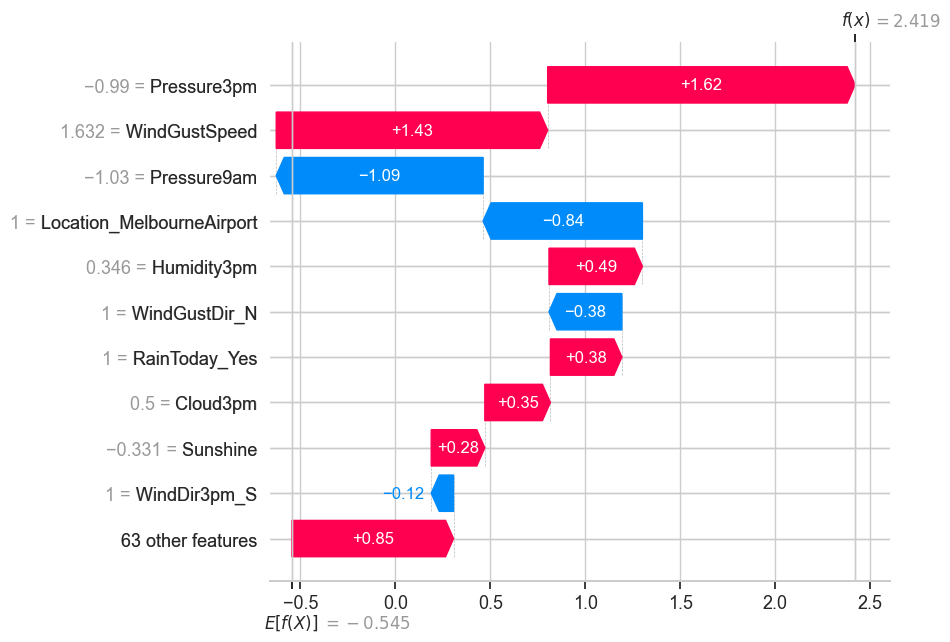

In [ ]:
shap.plots.waterfall(explanation, max_display=11)

El valor base es = -0.545. La prediccion de la variable RainTomorrow de una instancia se calcula f(x) = -0.545 + sum(SHSP values)

En la grafica observamos en rojo las variables que contribuyen positivamente al modelo de prediccion y en azul las que lo hacen negativamente. Sobre la misma, se refleja las cantidades de esa contribucion, las flechas tambien marcan la direccion en que impacta cada variable en la prediccion.

Observamos que entre las variables que mayor contribuyen positivamente estan:

**Pressure3pm, WindGustSpeed, Humidity3pm, RainToday_Yes, Cloud3pm,
Sunshine**, y

negativamente:  **Pressure9am, Location_MelbourneAirport,
WindGustDir_N, WindDir3pm_S.**

El resto de las variables aportan el 8.6% restante positivamente.

En la instancia considerada f(x) = 2.406

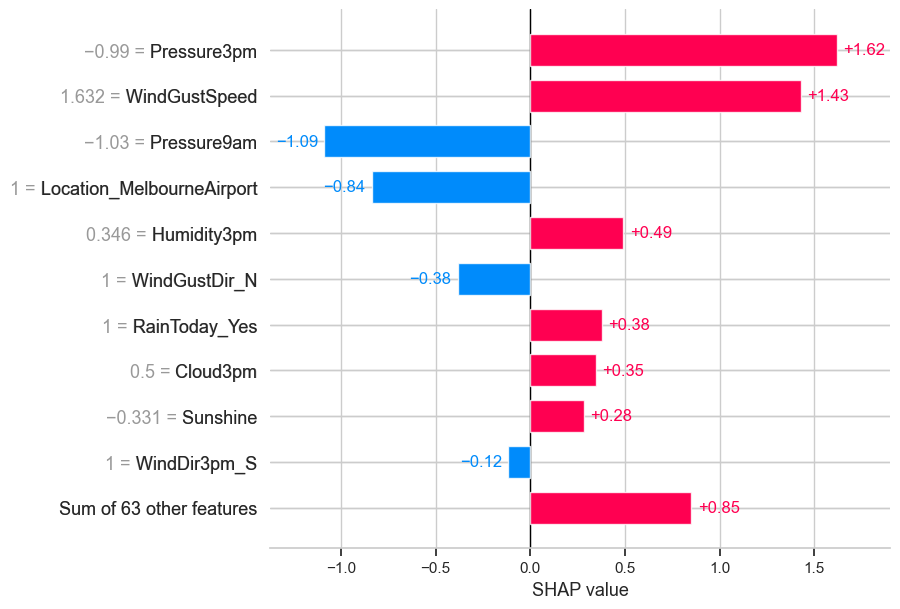

In [ ]:
shap.plots.bar(explanation, max_display=11)

En esta grafica, se observa claramente que las variables  **WindGustSpeed** y **Pressure3pm**, son las que mas influyen en positivamente en la prediccion, es decir, la cantidad de "lluvia_caida_mañana" aumente con valores altos de estas variables.

 Por el contrario, las variables **Pressure9am** y **Location_MelbourneAirport** son las que mas contribuyen negativamente al caida e lluvia.

INTERPRETABILIDAD GLOBAL CLASIFICACION

In [ ]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test_clasificacion)

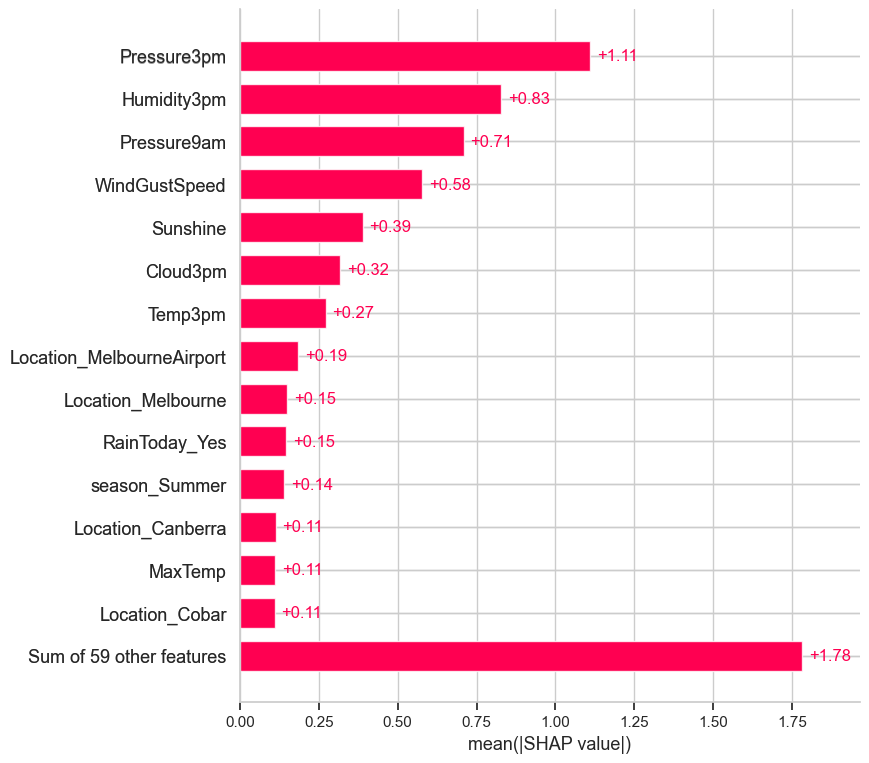

In [ ]:
shap.plots.bar(explanation, max_display=15)

En este grafico de barras, estan representadas las medias absolutas de los SHAP values, donde de mayor a menor, esa magnitud en valor absoluto refleja el impacto en la predicion para todas las instancias.



1.   **Pressure3pm (1.11)**
2.   **Humidity3pm(0.83)**
3.   **Pressure9pm (0.71)**
4.   **WndGustSpeed(0.58)**





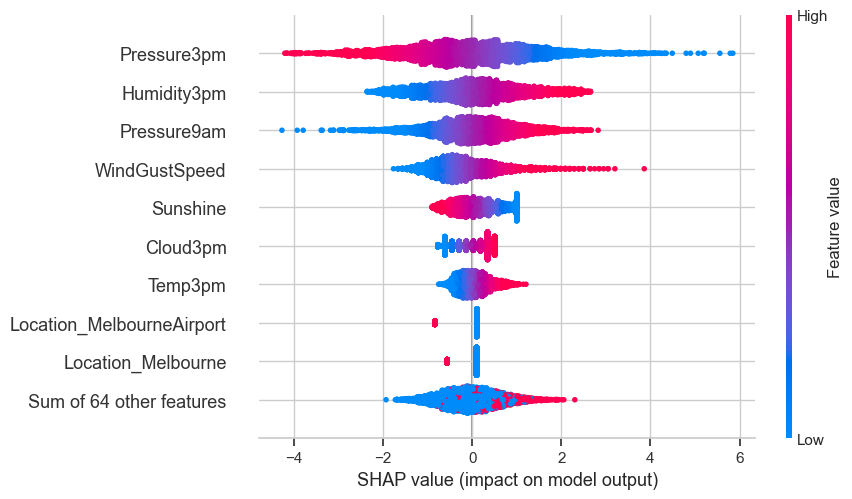

In [ ]:
shap.plots.beeswarm(explanation)

### Optimizacion parametros modelo de Regresion

No implementamos validacion cruzada ya que vamos a utilizar GridSearchCV y RandomSearchCV

GRID SEARCH con validacion cruzada

In [ ]:
params = {
       'fit_intercept': [True, False],
       'n_jobs': [None, 1],
       'positive': [True, False]}


In [ ]:
# función para entrenar y evaluar un modelo con hiperparámetros dados
def train_evaluate_model(params, X_train, y_train, X_test, y_test):
    model = LinearRegression(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

In [ ]:
grid_search = GridSearchCV(LinearRegression(), params, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train_scaled)
best_grid_params = grid_search.best_params_
best_grid_model = LinearRegression(**best_grid_params)
best_grid_model.fit(X_train_scaled, y_train_scaled)
grid_search_mse = mean_squared_error(y_test_scaled, best_grid_model.predict(X_test_scaled))

In [ ]:
best_grid_params

{'fit_intercept': False, 'n_jobs': None, 'positive': False}

RANDOM SEARCH con validacion cruzada

In [ ]:
random_search = RandomizedSearchCV(LinearRegression(),params, scoring='neg_mean_squared_error')
random_search.fit(X_train_scaled, y_train_scaled)
best_random_params = random_search.best_params_
best_random_model = LinearRegression(**best_random_params)
best_random_model.fit(X_train_scaled, y_train_scaled)
random_search_mse = mean_squared_error(y_test_scaled, best_random_model.predict(X_test_scaled))

In [ ]:
best_random_params

{'positive': False, 'n_jobs': None, 'fit_intercept': False}

In [ ]:
print("Grid Search MSE:", grid_search_mse)
print("Random Search MSE:", random_search_mse)

Grid Search MSE: 28.110049789407213
Random Search MSE: 28.110049789407213


### Optimizacion parametros modelo de Clasificacion

GRID SEARCH con validacion cruzada

In [96]:
grid_params = [
    {"class_weight": [None, 'balanced'], "C": [0.1, 1, 10,100], \
     "solver": ['newton-cg', 'lbfgs'], \
     "max_iter": [200, 500]}
]

grid_search = GridSearchCV(
    LogisticRegression(), grid_params )

grid_search.fit(X_train_scaled1, y_train_scaled1)

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'C': [0.1, 1, 10, 100],
                          'class_weight': [None, 'balanced'],
                          'max_iter': [200, 500],
                          'solver': ['newton-cg', 'lbfgs']}])

In [97]:
grid_search.best_params_

{'C': 10, 'class_weight': None, 'max_iter': 200, 'solver': 'newton-cg'}

Modelo de clasificacion optimizado con GridSearchCV

In [98]:
logreg_optimo = grid_search.best_estimator_

In [99]:
logreg_optimo.fit(X_train_scaled1, y_train_scaled1)

LogisticRegression(C=10, max_iter=200, solver='newton-cg')

In [100]:
y_pred_optimo = logreg_optimo.predict(X_test_scaled1)

In [101]:
print("Metricas de test con GridSearch")
print(metricas_clasificacion(y_test_scaled1, y_pred_optimo))

Metricas de test con GridSearch
Logloss:5.53
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      4159
         1.0       0.73      0.54      0.62      1255

    accuracy                           0.85      5414
   macro avg       0.80      0.74      0.76      5414
weighted avg       0.84      0.85      0.84      5414

(0.5394422310756972, 0.728740581270183)


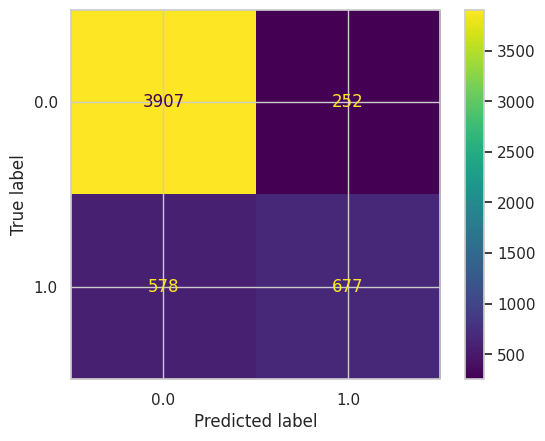

In [102]:
_ = ConfusionMatrixDisplay.from_estimator(logreg_optimo, X_test_scaled1, y_test_scaled1)

RANDOM SEARCH con validacion cruzada

In [103]:
random_params = [
    {"class_weight": [None, 'balanced'], "C": [0.1, 1, 10,100], \
     "solver": ['newton-cg', 'lbfgs'], \
     "max_iter": [200, 500]}
]

random_search = RandomizedSearchCV(LogisticRegression(), random_params)
random_search.fit(X_train_scaled1, y_train_scaled1)

RandomizedSearchCV(estimator=LogisticRegression(),
                   param_distributions=[{'C': [0.1, 1, 10, 100],
                                         'class_weight': [None, 'balanced'],
                                         'max_iter': [200, 500],
                                         'solver': ['newton-cg', 'lbfgs']}])

In [104]:
random_search.best_params_

{'solver': 'newton-cg', 'max_iter': 500, 'class_weight': None, 'C': 10}

Modelo de clasificacion optimizado con RandomizedSearchCV

In [105]:
logreg_optimo1 = random_search.best_estimator_

In [106]:
logreg_optimo1.fit(X_train_scaled1, y_train_scaled1)

LogisticRegression(C=10, max_iter=500, solver='newton-cg')

In [107]:
y_pred_optimo1 = logreg_optimo1.predict(X_test_scaled1)

In [108]:
print("Metricas de test con RandomdSearch")
print(metricas_clasificacion(y_test_scaled1, y_pred_optimo1))

Metricas de test con RandomdSearch
Logloss:5.53
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      4159
         1.0       0.73      0.54      0.62      1255

    accuracy                           0.85      5414
   macro avg       0.80      0.74      0.76      5414
weighted avg       0.84      0.85      0.84      5414

(0.5394422310756972, 0.728740581270183)


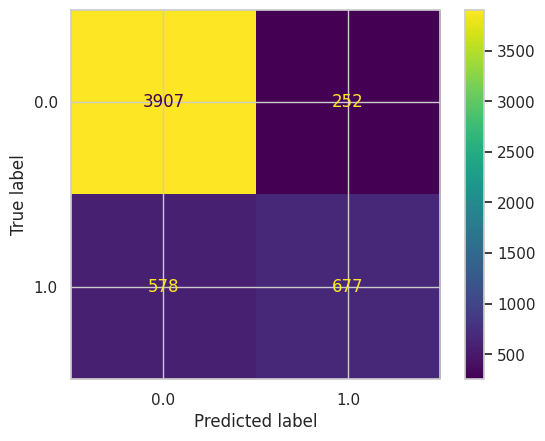

In [109]:
_ = ConfusionMatrixDisplay.from_estimator(logreg_optimo1, X_test_scaled1, y_test_scaled1)

## **RED NEURONAL**

### Modelo de REGRESION LINEAL

In [ ]:
# Definir la arquitectura de la red neuronal para regresión
def create_regression_model(input_shape):
    model = Sequential()
    model.add(Dense(126, input_dim=input_shape, activation='relu'))
    model.add(Dropout(0.5)) # Capa de Dropout para regularizacion, evita el overfitting
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))  # Capa de salida para regresión
    return model

# Crear el modelo
regression_model = create_regression_model(X_train_scaled.shape[1])

# Compilar el modelo
regression_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Entrenar el modelo
history_regression = regression_model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32)

y_pred_nn_regresion = regression_model.predict(X_test_scaled)
save_model(regression_model, 'regression_model.h5')

Epoch 1/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - loss: 35.9167 - mae: 2.3303
Epoch 2/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - loss: 30.7488 - mae: 1.9983
Epoch 3/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 28.5809 - mae: 1.7719
Epoch 4/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 27.2509 - mae: 1.7455
Epoch 5/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 21.2791 - mae: 1.6380
Epoch 6/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 23.0286 - mae: 1.6479
Epoch 7/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 24.8770 - mae: 1.6713
Epoch 8/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 23.1257 - mae: 1.6360
Epoch 9/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 23.4466 - mae: 1.6276
Epoch 10/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 25.0400 - mae: 1.6957
Epoch 11/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 22.1607 - mae: 1.6302
Epoch 12/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss:

In [ ]:
# Evaluar el modelo de train
mse_nn_train, mae_nn_train = regression_model.evaluate(X_train_scaled, y_train_scaled)

## Evaluar el modelo de test
mse_nn_test, mae_nn_test = regression_model.evaluate(X_test_scaled, y_test_scaled)


677/677 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.8331 - mae: 1.0778
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23.9662 - mae: 1.6005


In [ ]:
#Visualizar
#Calculamos metricas para train
y_pred_nn_regresion1 = regression_model.predict(X_train_scaled)
print('Metricas de Train de NN:')
print(metricas_regresion(y_train_scaled, y_pred_nn_regresion1))

#Calculamos metricas para test
y_pred_nn_regresion2 = regression_model.predict(X_test_scaled)
print('Metricas de Test de NN:')
print(metricas_regresion(y_test_scaled, y_pred_nn_regresion2))

677/677 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Metricas de Train de NN:
R2:   0.78
MSE:  8.61
MAE:  1.12
None
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Metricas de Test de NN:
R2:   0.43
MSE:  25.88
MAE:  1.64
None


###Modelo de CLASIFICACION

In [ ]:
# Verificar las formas de los datos
print("Forma de X_smote_train:", X_smote_train.shape)
print("Forma de y_smote_train:", y_smote_train.shape)
print("Forma de X_smote_test:", X_smote_test.shape)
print("Forma de y_smote_test:", y_smote_test.shape)

# Convertir los datos a float32
X_smote_train = np.array(X_smote_train, dtype=np.float32)
y_smote_train = np.array(y_smote_train, dtype=np.float32)
X_smote_test = np.array(X_smote_test, dtype=np.float32)
y_smote_test = np.array(y_smote_test, dtype=np.float32)

# Definir la arquitectura del modelo de clasificación
def create_classification_model(input_shape):
    model = Sequential()
    model.add(Dense(126, input_dim=input_shape, activation='relu'))
    model.add(Dropout(0.5))  # Capa de Dropout para regularización, evita el overfitting
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Capa de salida para clasificación binaria
    return model

# Crear el modelo
classification_model = create_classification_model(X_smote_train.shape[1])

# Compilar el modelo
classification_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['Precision'])

# Entrenar el modelo
history_classification = classification_model.fit(X_smote_train, y_smote_train, epochs=100, batch_size=32)

# Evaluar el modelo de train
logloss_nn_train, precision_nn_train = classification_model.evaluate(X_smote_train, y_smote_train)
print(f"Train - Logloss: {logloss_nn_train}, Precision: {precision_nn_train}")

# Evaluar el modelo de test
logloss_nn_test, precision_nn_test = classification_model.evaluate(X_smote_test, y_smote_test)
print(f"Test - Logloss: {logloss_nn_test}, Precision: {precision_nn_test}")


Forma de X_smote_train: (33236, 73)
Forma de y_smote_train: (33236,)
Forma de X_smote_test: (8318, 73)
Forma de y_smote_test: (8318,)
Epoch 1/100
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Precision: 0.7012 - loss: 0.5932
Epoch 2/100
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - Precision: 0.7771 - loss: 0.4516
Epoch 3/100
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - Precision: 0.7963 - loss: 0.4208
Epoch 4/100
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - Precision: 0.8010 - loss: 0.4060
Epoch 5/100
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - Precision: 0.8135 - loss: 0.3903
Epoch 6/100
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - Precision: 0.8179 - loss: 0.3821
Epoch 7/100
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - Precision: 0.8185 - loss: 0.3743
Epoch 8/100
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - Precision: 0.8256 - loss: 0.3600
Epoch 9/100
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - Precision: 0.8310 - loss: 0.3509
Epoch 10/100
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/ste

In [ ]:

# Evaluar el modelo de train
logloss_nn_train, precision_nn_train = classification_model.evaluate(X_smote_train, y_smote_train)

## Evaluar el modelo de test
logloss_nn_test, precision_nn_test = classification_model.evaluate(X_smote_test, y_smote_test)

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - Precision: 0.8422 - loss: 0.1628
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Precision: 0.7135 - loss: 0.4967


### **Optimizacion de hiperparametros con Optuna**

### Particion en train y validacion



Particion para regresion

In [ ]:
valid_size = int(0.2 * len(X_train_scaled))
valid_size

4331

In [ ]:
#Todas las filas menos las ultimas
X_train_part_reg = X_train_scaled[:-valid_size]
y_train_part_reg = y_train_scaled[:-valid_size]

#Busca las ultimas filas
X_train_valid_reg = X_train_scaled[-valid_size:]
y_train_valid_reg= y_train_scaled[-valid_size:]

Particion para clasificacion.


In [ ]:
valid_size1 = int(0.2 * len(X_smote_train))
print("valid_size:", valid_size)

X_train_part_clas = X_smote_train[:-valid_size1]
y_train_part_clas = y_smote_train[:-valid_size1]

X_train_valid_clas = X_smote_train[-valid_size1:]
y_train_valid_clas = y_smote_train[-valid_size1:]

# Verificación de las dimensiones
print("X_train_part shape:", X_train_part_clas.shape)
print("y_train_part shape:", y_train_part_clas.shape)
print("X_train_valid shape:", X_train_valid_clas.shape)
print("y_train_valid shape:", y_train_valid_clas.shape)

valid_size: 4331
X_train_part shape: (26589, 73)
y_train_part shape: (26589,)
X_train_valid shape: (6647, 73)
y_train_valid shape: (6647,)


**OPTUNA PARA MODELO DE REGRESION**

In [ ]:
def objective(trial):
    # Hiperparámetros a optimizar
    num_layers = trial.suggest_int('num_layers', 1, 3)
    model = Sequential()

    # Construir el modelo
    input_shape = X_train_part_reg.shape[1]
    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128)
        if i == 0:
            model.add(Dense(num_units, activation='relu', input_dim=input_shape))
        else:
            model.add(Dense(num_units, activation='relu'))

    # Capa de salida
    model.add(Dense(1)) # Para regresión

    # Compilar el modelo
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    # Entrenar el modelo
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    model.fit(X_train_part_reg, y_train_part_reg, validation_data=(X_train_valid_reg, y_train_valid_reg), epochs=5, batch_size=batch_size, verbose=0)

    # Evaluar el modelo
    score = model.evaluate(X_train_valid_reg, y_train_valid_reg, verbose=0)
    return score[1]

# Crear un estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Obtener los mejores hiperparámetros
best_params_reg = study.best_params
print("Mejores parametros para regresion:", best_params_reg)


[I 2024-06-22 12:32:13,612] A new study created in memory with name: no-name-4d9a584f-7a4d-44cc-b345-949a2d32a2bb
[I 2024-06-22 12:32:30,910] Trial 0 finished with value: 2.8375816345214844 and parameters: {'num_layers': 3, 'n_units_layer_0': 79, 'n_units_layer_1': 19, 'n_units_layer_2': 36, 'learning_rate': 0.07742398466713309, 'batch_size': 32}. Best is trial 0 with value: 2.8375816345214844.
[I 2024-06-22 12:32:52,326] Trial 1 finished with value: 2.1009278297424316 and parameters: {'num_layers': 3, 'n_units_layer_0': 110, 'n_units_layer_1': 120, 'n_units_layer_2': 63, 'learning_rate': 1.2304985019171153e-05, 'batch_size': 32}. Best is trial 0 with value: 2.8375816345214844.
[I 2024-06-22 12:33:01,767] Trial 2 finished with value: 1.900051236152649 and parameters: {'num_layers': 1, 'n_units_layer_0': 36, 'learning_rate': 0.0002282461868711888, 'batch_size': 64}. Best is trial 0 with value: 2.8375816345214844.
[I 2024-06-22 12:33:12,926] Trial 3 finished with value: 2.120968818664551

Mejores parametros para regresion: {'num_layers': 3, 'n_units_layer_0': 79, 'n_units_layer_1': 19, 'n_units_layer_2': 36, 'learning_rate': 0.07742398466713309, 'batch_size': 32}


In [ ]:
# Función para crear el modelo de regresión con los mejores hiperparámetros
def create_regression_model_with_params(input_shape, best_params):
    model = Sequential()
    for i in range(best_params['num_layers']):
        if i == 0:
            model.add(Dense(best_params[f'n_units_layer_{i}'], activation='relu', input_dim=input_shape))
        else:
            model.add(Dense(best_params[f'n_units_layer_{i}'], activation='relu'))
    model.add(Dense(1)) # Capa de salida para regresión
    return model

# Crear el modelo de regresión con los mejores hiperparámetros
regression_model_best_params = create_regression_model_with_params(X_train_scaled.shape[1], best_params_reg)

# Compilar el modelo
regression_model_best_params.compile(optimizer=Adam(learning_rate=best_params_reg['learning_rate']), loss='mse', metrics=['mae'])

# Entrenar el modelo utilizando los datos de entrenamiento y validación utilizados durante la optimización
history_regression_best_params = regression_model_best_params.fit(X_train_part_reg,\
                                y_train_part_reg, epochs=100, validation_data=(X_train_valid_reg, y_train_valid_reg), batch_size=32)

# Evaluar el modelo utilizando los datos de prueba
mse_best_params, mae_best_params = regression_model_best_params.evaluate(X_test_scaled, y_test_scaled)
print(f"MSE con los mejores parametros: {mse_best_params}, MAE con mejores parametros: {mae_best_params}")

# Predecir utilizando los datos de prueba
y_pred_nn_regression_best_params = regression_model_best_params.predict(X_test_scaled)


Epoch 1/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 35.6988 - mae: 2.7229 - val_loss: 35.8757 - val_mae: 2.6916
Epoch 2/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 37.2469 - mae: 2.9744 - val_loss: 35.8692 - val_mae: 2.6785
Epoch 3/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 42.8100 - mae: 3.1979 - val_loss: 35.8489 - val_mae: 2.6107
Epoch 4/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 36.0580 - mae: 2.9829 - val_loss: 36.0831 - val_mae: 2.8969
Epoch 5/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 41.8516 - mae: 3.2209 - val_loss: 35.8866 - val_mae: 2.7104
Epoch 6/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 40.6763 - mae: 3.0482 - val_loss: 35.9330 - val_mae: 2.7710
Epoch 7/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 40.6548 - mae: 3.0576 - val_loss: 35.8473 - val_mae: 2.5857
Epoch 8/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 39.6990 - mae: 2.9636 - val_loss: 36.3492 - val_mae: 3.0466
Epoch 9/100
542/542 ━━━━━━━━━━━━

In [ ]:
# Evaluar el modelo de train
mse_nn_train_best, mae_nn_train_best = regression_model.evaluate(X_train_scaled, y_train_scaled)

## Evaluar el modelo de test
mse_nn_test_best, mae_nn_test_best = regression_model.evaluate(X_test_scaled, y_test_scaled)

677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.8331 - mae: 1.0778
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23.9662 - mae: 1.6005


In [ ]:
#Visualizar
#Calculamos metricas para train
y_pred_nn_regresion1 = regression_model.predict(X_train_scaled)
print('Metricas de best_Train de NN:')
print(metricas_regresion(y_train_scaled, y_pred_nn_regresion1))

#Calculamos metricas para test
y_pred_nn_regresion2 = regression_model.predict(X_test_scaled)
print('Metricas de best_Test de NN:')
print(metricas_regresion(y_test_scaled, y_pred_nn_regresion2))

677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Metricas de best_Train de NN:
R2:   0.78
MSE:  8.61
MAE:  1.12
None
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Metricas de best_Test de NN:
R2:   0.43
MSE:  25.88
MAE:  1.64
None


### **Optuna para Modelo de Clasificación**

In [ ]:
def objective(trial):
    # Hiperparámetros a optimizar
    num_layers = trial.suggest_int('num_layers', 1, 3)
    model = Sequential()

    # Construir el modelo
    input_shape = X_train_part_clas.shape[1]
    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128)
        if i == 0:
            model.add(Dense(num_units, activation='relu', input_dim=input_shape))
        else:
            model.add(Dense(num_units, activation='relu'))

    # Capa de salida
    model.add(Dense(1, activation='sigmoid')) # Para clasificación binaria

    # Compilar el modelo
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['Precision'])

    # Entrenar el modelo
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    model.fit(X_train_part_clas, y_train_part_clas, validation_data=(X_train_valid_clas, y_train_valid_clas), epochs=5, batch_size=batch_size, verbose=0)

    # Evaluar el modelo
    score = model.evaluate(X_train_valid_clas, y_train_valid_clas, verbose=0)
    return score[1]

# Crear un estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparametros encontrados:" ,best_params)

[I 2024-06-22 12:50:03,350] A new study created in memory with name: no-name-564420fd-1a1c-4134-83ee-8805b390cb87
[I 2024-06-22 12:50:18,563] Trial 0 finished with value: 1.0 and parameters: {'num_layers': 2, 'n_units_layer_0': 18, 'n_units_layer_1': 76, 'learning_rate': 1.4523724286142505e-05, 'batch_size': 64}. Best is trial 0 with value: 1.0.
[I 2024-06-22 12:50:31,950] Trial 1 finished with value: 1.0 and parameters: {'num_layers': 2, 'n_units_layer_0': 45, 'n_units_layer_1': 62, 'learning_rate': 0.0072208173048569635, 'batch_size': 64}. Best is trial 0 with value: 1.0.
[I 2024-06-22 12:50:49,923] Trial 2 finished with value: 1.0 and parameters: {'num_layers': 2, 'n_units_layer_0': 70, 'n_units_layer_1': 53, 'learning_rate': 1.5157610990285242e-05, 'batch_size': 32}. Best is trial 0 with value: 1.0.
[I 2024-06-22 12:51:01,909] Trial 3 finished with value: 1.0 and parameters: {'num_layers': 3, 'n_units_layer_0': 12, 'n_units_layer_1': 111, 'n_units_layer_2': 28, 'learning_rate': 0.0

Mejores hiperparametros encontrados: {'num_layers': 2, 'n_units_layer_0': 18, 'n_units_layer_1': 76, 'learning_rate': 1.4523724286142505e-05, 'batch_size': 64}


In [ ]:
# Definir la función para crear el modelo de clasificación con los mejores hiperparámetros
def create_classification_model_with_params(input_shape, best_params):
    model = Sequential()
    model.add(Dense(best_params['n_units_layer_0'], input_dim=input_shape, activation='relu'))  # Capa de entrada
    for i in range(1, best_params['num_layers']):
        model.add(Dense(best_params[f'n_units_layer_{i}'], activation='relu'))  # Capas ocultas
    model.add(Dense(1, activation='sigmoid'))  # Capa de salida para clasificación binaria
    return model


# Obtener los mejores hiperparámetros encontrados por Optuna
best_params = study.best_params

# Crear el modelo de clasificación con los mejores hiperparámetros
classification_model_best_params = create_classification_model_with_params(X_smote_train.shape[1], best_params)

# Compilar el modelo
classification_model_best_params.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['Precision'])

# Entrenar el modelo
history_classification = classification_model_best_params.fit(X_train_part_clas, y_train_part_clas, epochs=50, validation_split=0.2, batch_size=32)

# Evaluar el modelo utilizando los datos de prueba X_smote_test y y_smote_test
loss, precision = classification_model_best_params.evaluate(X_smote_test, y_smote_test)
print(f"Loss: {loss}, Precision: {precision}")

# Predecir utilizando los datos de prueba X_smote_test
y_pred_nn_classification = classification_model_best_params.predict(X_smote_test)

save_model(classification_model_best_params, 'classification_model_optimized.h5')

Epoch 1/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - Precision: 0.6167 - loss: 0.4533 - val_Precision: 0.9972 - val_loss: 0.7833
Epoch 2/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - Precision: 0.7202 - loss: 0.3548 - val_Precision: 0.9979 - val_loss: 0.7676
Epoch 3/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - Precision: 0.7374 - loss: 0.3457 - val_Precision: 0.9958 - val_loss: 0.6710
Epoch 4/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - Precision: 0.7510 - loss: 0.3342 - val_Precision: 0.9979 - val_loss: 0.7791
Epoch 5/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - Precision: 0.7538 - loss: 0.3341 - val_Precision: 0.9979 - val_loss: 0.7696
Epoch 6/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - Precision: 0.7495 - loss: 0.3248 - val_Precision: 0.9986 - val_loss: 0.7329
Epoch 7/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - Precision: 0.7559 - loss: 0.3201 - val_Precision: 0.9971 - val_loss: 0.6783
Epoch 8/50
665/665 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - Precision: 0.7632 - 

In [ ]:
# Evaluar el modelo de train
logloss_nn_train_best, precision_nn_train_best = classification_model_best_params.evaluate(X_smote_train, y_smote_train)

## Evaluar el modelo de test
logloss_nn_test_best, precision_nn_test_best = classification_model_best_params.evaluate(X_smote_test, y_smote_test)

1039/1039 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - Precision: 0.8778 - loss: 0.2851
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - Precision: 0.7796 - loss: 0.4267


## Explicabilidad local del Modelo de Regresion de Redes Neuronales

Para SHAP usamos squeeze para reducir la dimensionalidad, eliminando dimensiones innecesarias y asegurando que los datos tengan la estructura adecuada.

In [ ]:
feature_names1 = X_train_regresion.columns.values
feature_names1

array(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'WindGustDir_SW',
       'WindDir9am_SW', 'WindDir3pm_SW', 'WindGustDir_S', 'WindDir9am_S',
       'WindDir3pm_S', 'WindGustDir_SSW', 'WindDir9am_SSW',
       'WindDir3pm_SSW', 'WindGustDir_W', 'WindDir9am_W', 'WindDir3pm_W',
       'WindGustDir_SSE', 'WindDir9am_SSE', 'WindDir3pm_SSE',
       'WindGustDir_E', 'WindDir9am_E', 'WindDir3pm_E', 'WindGustDir_SE',
       'WindDir9am_SE', 'WindDir3pm_SE', 'WindGustDir_NE',
       'WindDir9am_NE', 'WindDir3pm_NE', 'WindGustDir_NNE',
       'WindDir9am_NNE', 'WindDir3pm_NNE', 'WindGustDir_WSW',
       'WindDir9am_WSW', 'WindDir3pm_WSW', 'WindGustDir_WNW',
       'WindDir9am_WNW', 'WindDir3pm_WNW', 'WindGustDir_NW',
       'WindDir9am_NW', 'WindDir3pm_NW', 'WindGustDir_N', 'WindDir9am_N',
       'WindDir3

In [ ]:

sample_size = 100

X_train_sample = X_train_part_reg[:sample_size]
explainer_reg = shap.DeepExplainer(regression_model_best_params, X_train_sample)

# Calcular los valores SHAP para todos los ejemplos de prueba
shap_values_reg = explainer_reg.shap_values(X_test_scaled)

idx = 0

# Asegurarse de que los valores SHAP tengan la forma correcta
shap_value_for_example = shap_values_reg[idx]

# Convertir a NumPy array si es necesario
if isinstance(shap_value_for_example, tf.Tensor):
    shap_value_for_example = shap_value_for_example.numpy()

# Asegurarse de que no sea un tensor escalar y tenga la forma adecuada
if np.ndim(shap_value_for_example) > 1:
    shap_value_for_example = np.squeeze(shap_value_for_example)

# Obtener el valor base (expected_value)
base_value = explainer_reg.expected_value.numpy()  # Convertir a NumPy array

feature_names = list(X_train_regresion.columns)

# Crear un objeto de explicación SHAP para el ejemplo seleccionado
explanation = shap.Explanation(values=shap_value_for_example,
                               base_values=base_value,
                               feature_names=feature_names)

# Visualizar la interpretación del ejemplo seleccionado
shap.waterfall_plot(explanation)

En este caso decidimos usar una muestra de 100 para reducir el tiempo de ejecusion y elegimos el ejemplo 0.

Se puede observar como las 3 variables mas significativas que influyen positivamente son:

**Rainfall, WindGustSpeed y Humidity3pm: Contribuyen a aumentar la prediccion del modelo,cuanto mas llueva hoy, mayor  velocidad del viento y mayor sea la humedad a las 3pm,  mas alto sera el valor que predice el modelo.

Las que influyen negativamente son: season_Spring, Location_MelbourneAirport, WindDir3pm_S , es decir,  reduce la cantidad de  lluvia que caera.

## Explicabilidad global del modelo de regresion de Redes Neuronales

Aplicamos la clase shap.DeepExplainer para trabajar con modelos de redes neuronales ya que es mas eficiente.

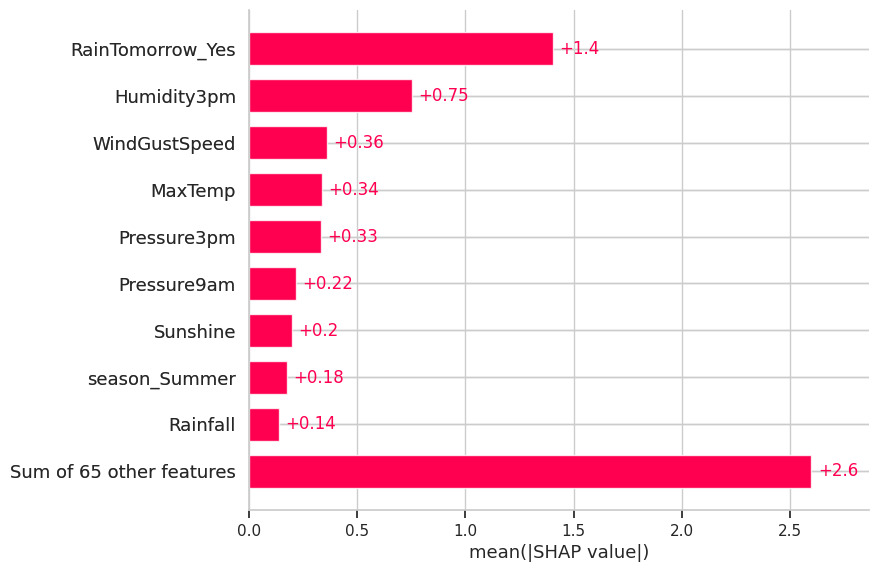

In [ ]:
sample_size = 100
X_train_sample = X_train_part_reg[:sample_size]

# Crear un objeto explainer SHAP para el modelo de regresión usando DeepExplainer
explainer_reg = shap.DeepExplainer(regression_model_best_params, X_train_sample)

# Calcular los valores SHAP para todos los ejemplos de prueba
shap_values_reg = explainer_reg.shap_values(X_test_scaled)

# Convertir a NumPy array si es necesario (en este caso, es probable que ya sea un ndarray)
shap_values_reg = [sv.numpy() if isinstance(sv, tf.Tensor) else sv for sv in shap_values_reg]

# Asegurarse de que los valores SHAP tengan la forma correcta
shap_values_reg = np.squeeze(shap_values_reg)

# Obtener el valor base (expected_value)
base_value = explainer_reg.expected_value.numpy()

feature_names = list(X_train_regresion.columns)

# Crear un objeto de explicación SHAP para la interpretación global
explanation = shap.Explanation(values=shap_values_reg,
                               base_values=base_value,
                               feature_names=feature_names)

# Visualizar la importancia de las características a nivel global
shap.plots.bar(explanation)

En este grafico de barras, estan representadas las medias absolutas de los SHAP values, donde de mayor a menor, esa magnitud en valor absoluto refleja el impacto en la predicion para todas las instancias.

Estas son: **RainTomorrow_Yes, Humidity3pm, WindGustSpeed, MaxTemp**

## Explicabilidad local para el Modelo de Clasificacion de Redes Neuronales

Usamos KernelExplainer ya que es mas robusto para estos casos.

2/2 [==============================] - 0s 6ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

3410/3410 [==============================] - 6s 2ms/step


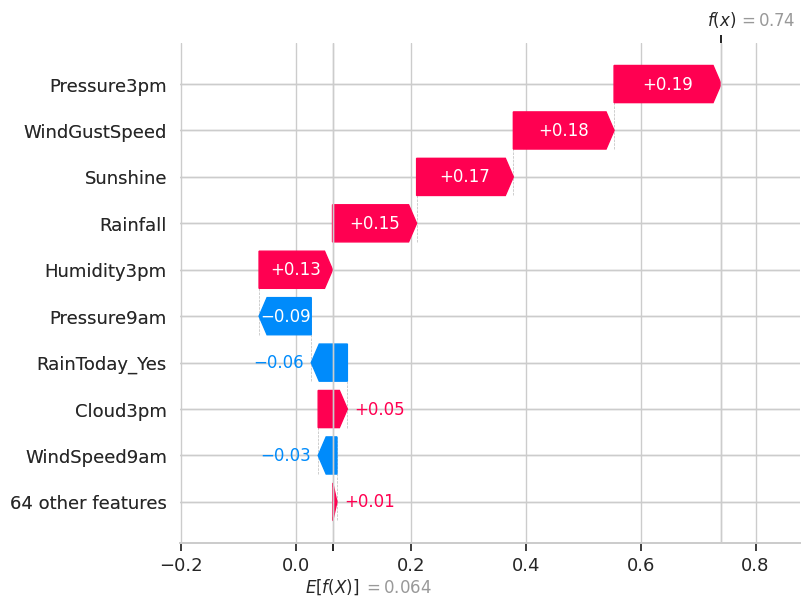

In [ ]:
sample_size = 50

X_train_sample = X_train_part_clas[:sample_size]

# Crear un objeto explainer SHAP para el modelo de clasificación usando el KernelExplainer
explainer_clas = shap.KernelExplainer(classification_model.predict, X_train_sample)

# Seleccionar una muestra de tus datos de prueba para calcular los valores SHAP
X_test_sample = X_test_scaled1[:sample_size]

# Calcular los valores SHAP para la muestra de ejemplos de prueba
shap_values_clas = explainer_clas.shap_values(X_test_sample)

# Aplicar squeeze a los valores SHAP para asegurarse de que tengan la forma correcta
shap_values_clas = np.squeeze(shap_values_clas)

idx = 0

# Predecir las probabilidades de clase para el ejemplo seleccionado
predicted_probabilities = classification_model.predict(X_test_sample)
predicted_class = np.argmax(predicted_probabilities[idx])  # Obtener la clase con la probabilidad más alta

# Calcular los valores SHAP para el ejemplo seleccionado (local)
shap_values_clas_single = explainer_clas.shap_values(X_test_sample[idx:idx+1])

# Aplicar squeeze a los valores SHAP para el ejemplo seleccionado
shap_values_clas_single = np.squeeze(shap_values_clas_single[predicted_class])

feature_names = list(X_train_clasificacion.columns)

# Crear el objeto Explanation para el ejemplo seleccionado
explanation_clas_single = shap.Explanation(values=shap_values_clas_single,
                                           base_values=explainer_clas.expected_value[predicted_class],
                                           feature_names=feature_names)

# Generar el gráfico de waterfall para la interpretación local
shap.plots.waterfall(explanation_clas_single)

En este caso,hemos usado una muestra de 50 para reducir el tiempo de ejecusion y elegimos el ejemplo 0. En la grafica observamos en rojo las variables que contribuyen positivamente al modelo de prediccion y en azul las que lo hacen negativamente. Sobre la misma, se refleja las cantidades de esa contribucion, las flechas tambien marcan la direccion en que impacta cada variable en la prediccion.

Impactan positivamente: **Pressure3pm, Sunshine, WindGusSpeed, Rainnfall,Humdity3pm.**

Impactan negativamente: **Pressure9am**

## Explicabilidad global para el Modelo de Clasificacion de  Redes Neuronales

2/2 [==============================] - 0s 5ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

3407/3407 [==============================] - 5s 2ms/step


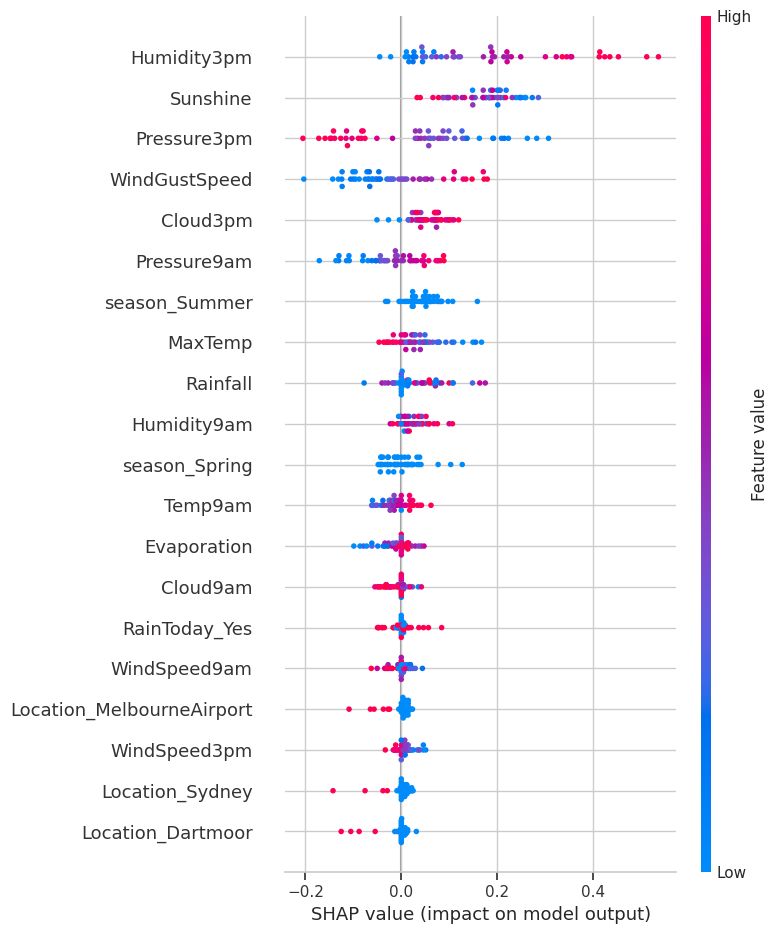

In [ ]:
sample_size = 50

X_train_sample = X_train_part_clas[:sample_size]

# Crear un objeto explainer SHAP para el modelo de clasificación usando el KernelExplainer
explainer_clas = shap.KernelExplainer(classification_model.predict, X_train_sample)

X_test_sample = X_test_scaled1[:sample_size]

# Calcular los valores SHAP para la muestra de ejemplos de prueba
shap_values_clas = explainer_clas.shap_values(X_test_sample)

# Aplicar squeeze a los valores SHAP para asegurarse de que tengan la forma correcta
shap_values_clas = np.squeeze(shap_values_clas)

feature_names = list(X_train_clasificacion.columns)

# Crear el objeto Explanation para los valores SHAP globales
explanation_clas_global = shap.Explanation(values=shap_values_clas,
                                           base_values=explainer_clas.expected_value,
                                           feature_names=feature_names)

# Generar el gráfico de resumen de valores SHAP para interpretación global
shap.summary_plot(shap_values_clas, X_test_sample, feature_names=feature_names)

En este grafico se pueden observar las variables mas significativas. Las características con valores SHAP más altos (rojos) están asociadas con predicciones más altas, mientras que las características con valores SHAP más bajos (azules) están asociadas con predicciones más bajas.

En comparacioncon los modelos de Regresion y Clasificacion evaluadoas anteriormente, las redes  neuronales toman otras features en algunos casos y en otras coinciden con los modelos anteriores pero cambia en orden de importancia y  lainfluencia de la caracteristica en la prediccion.

**COMPARACION MODELOS DE REGRESION**

In [ ]:
modelos_regresion = [regresion, gradiente, ridge, lasso,elastic, \
                     best_grid_model, best_random_model, regression_model, \
                     regression_model_best_params]

In [ ]:
print("Comparacion de modelos")
print("Modelo_base")
print(metricas_regresion_comparar(y_test_scaled, regresion_base.predict(X_test_base_scaled)))
for modelo in modelos_regresion:
    print(f"Modelo:{modelo}")
    print(metricas_regresion_comparar(y_test_scaled, modelo.predict(X_test_scaled)))

Comparacion de modelos
Modelo_base
MSE:  40.22
MAE:  2.98
None
Modelo:LinearRegression()
MSE:  28.11
MAE:  2.26
None
Modelo:SGDRegressor()
MSE:  31.87
MAE:  2.27
None
Modelo:RidgeCV()
MSE:  28.12
MAE:  2.26
None
Modelo:LassoCV()
MSE:  28.28
MAE:  2.17
None
Modelo:ElasticNetCV()
MSE:  28.51
MAE:  2.15
None
Modelo:LinearRegression(fit_intercept=False)
MSE:  28.11
MAE:  2.26
None
Modelo:LinearRegression(fit_intercept=False)
MSE:  28.11
MAE:  2.26
None
Modelo:<Sequential name=sequential, built=True>
170/170 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step
MSE:  25.88
MAE:  1.64
None
Modelo:<Sequential name=sequential_33, built=True>
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
MSE:  45.23
MAE:  3.11
None


El mejor modelo de regresion que hemos obtenido es regresion_model.
Es un modelo de Red Neuronal .
Comparamos dos metricas MAE y MSE. Nos quedamos con la metrica MAE ya que es menos sensible a outliers como determinante para la eleccion del modelo

**COMPARACION MODELOS DE CLASIFICACION**

In [ ]:
modelos_clasificacion = [logreg, reglog_smote, gnb, logreg_optimo, \
                         logreg_optimo1]

In [ ]:
print("Comparacion de modelos de Clasificacion")
for modelo in modelos_clasificacion:
    print(f"Modelo:{modelo}")
    print(metricas_clasificacion_comparar(y_test_scaled1, modelo.predict(X_test_scaled1)))
print("Modelo: classification_model de NN")
print ( "Precision:", precision_nn_test,"\n")
print("Modelo: classification_model_best_params de NN")
print ( "Precision:", precision_nn_test_best)

Comparacion de modelos de Clasificacion
Modelo:LogisticRegression(class_weight='balanced', random_state=42)
Precision:  0.77
None
Modelo:LogisticRegression(random_state=42)
Precision:  0.76
None
Modelo:GaussianNB()
Precision:  0.65
None
Modelo:LogisticRegression(C=1, max_iter=200, random_state=42)
Precision:  0.54
None
Modelo:LogisticRegression(C=10, max_iter=200, random_state=42, solver='newton-cg')
Precision:  0.54
None
Modelo: classification_model de NN
Precision: 0.8761574029922485 

Modelo: classification_model_best_params de NN
Precision: 0.9029819369316101


Dentro de los modelos de clasificacion evaluados utilizando como metrica de comparacion la precision, obtuvimos los mejores resultados con redes neuronales optimizadas, por lo que seleccionamos el modelo clasification_model_best_params

# Conclusiones

El dataset cuenta con muchos valores nulos, especialmente en las columnas Evaporation, Sunshine, WindGustDir, WindGustSpeed, WindDir9am, Coud9am, cloud3pm, de las cuales **Sunshine, WindGustDir, WindGustSpeed, WindDir9am**, como vemos en Shap, contribuyen significativamente en la prediccion entre otras.

Los valores faltantes en todas las columnas, los reemplazammos,agrupando las ciudades por fecha y calculando la moda para ese dia.

En el analisis descriptivo, observamos que los dias de lluvia por estacion son muy pocos: 26 en invierno,  20 en primavera y otoño y en verano de 15 dias. La variable RainTomorrow que debemos predecir es la variable minoritaria con un 23% de observaciones.
Con respecto  a la variable RainfallTomorrow no presenta correlacion lineal fuerte con ninguna de las otras variables presentes.

Estudiamos deferentes modelos de Regresion Lineal y Red neuronal para regresion para predecir la variable RainfallTomorrow, los cuales evaluamos con diferentes metricas para ver su rendimiento, quedandonos con MAE por ser menos suceptible a los outliers, a fin de elegir el mejor para la implementacion.

Para predecir la variable RainTomorrow, implementamos diferentes modelos de clasificacion y red neuronal para clasificacion con y sin optimizacion y aplicamos oversampling con Smote para mejorar la prediccion. Para evaluar su eficiencia elegimos la precision como metrica.

De acuerdo a lo expuesto, elegimos a los modelos de Red neuronal para la puesta en produccion.

Cabe destacar, el tiempo computacional y de recursos que implica el desarrollo de un modelo neuronal, superior a todos los otros modelos,
deberia analizarse previamente un estudio para ver si el proyecto amerita este modelo o puede llegare a resultados optimos con cualquiera d los otros analizados.